In [1]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import random
import os
import pandas as pd
from pandas import datetime
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font',family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False) # 한글폰트를 사용하며 마이너스폰트가 깨져 이렇게 설정
from IPython.display import set_matplotlib_formats
%config InlineBackend.figure_format = 'retina' # 폰트 선명하게 보이기 위해
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import statsmodels.api as sm

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(41) # Seed 고정

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/LG/train.csv') #.drop(columns=['제품']) # 판매량
brand_keyword = pd.read_csv('/content/drive/MyDrive/LG/brand_keyword_cnt.csv') # 브랜드 연관키워드 언급 정도
product_info = pd.read_csv('/content/drive/MyDrive/LG/product_info.csv') # 제품 정보
sales = pd.read_csv('/content/drive/MyDrive/LG/sales.csv') # 총 판매금액

train = train.rename(columns={
    '제품': 'Product',
    '대분류': 'Big_cat',
    '중분류': 'Mid_cat',
    '소분류': 'Small_cat',
    '브랜드': 'Brand',
    '쇼핑몰': 'mall'
})

In [ ]:
'''# 데이터프레임을 날짜 열을 일자로 변환하고, 피벗하여 구조를 변경
train = train.melt(id_vars=['ID', 'Product', 'Big_cat', 'Mid_cat', 'Small_cat', 'Brand','mall'],
                    var_name='time', value_name='sell')
train['time'] = pd.to_datetime(train['time'], format='%Y-%m-%d')

cols = train.columns.tolist()
cols.insert(0, cols.pop(cols.index('time')))
train = train[cols]
train'''

"# 데이터프레임을 날짜 열을 일자로 변환하고, 피벗하여 구조를 변경\ntrain = train.melt(id_vars=['ID', 'Product', 'Big_cat', 'Mid_cat', 'Small_cat', 'Brand','mall'],\n                    var_name='time', value_name='sell')\ntrain['time'] = pd.to_datetime(train['time'], format='%Y-%m-%d')\n\ncols = train.columns.tolist()\ncols.insert(0, cols.pop(cols.index('time')))\ntrain = train[cols]\ntrain"

# Sell by mall

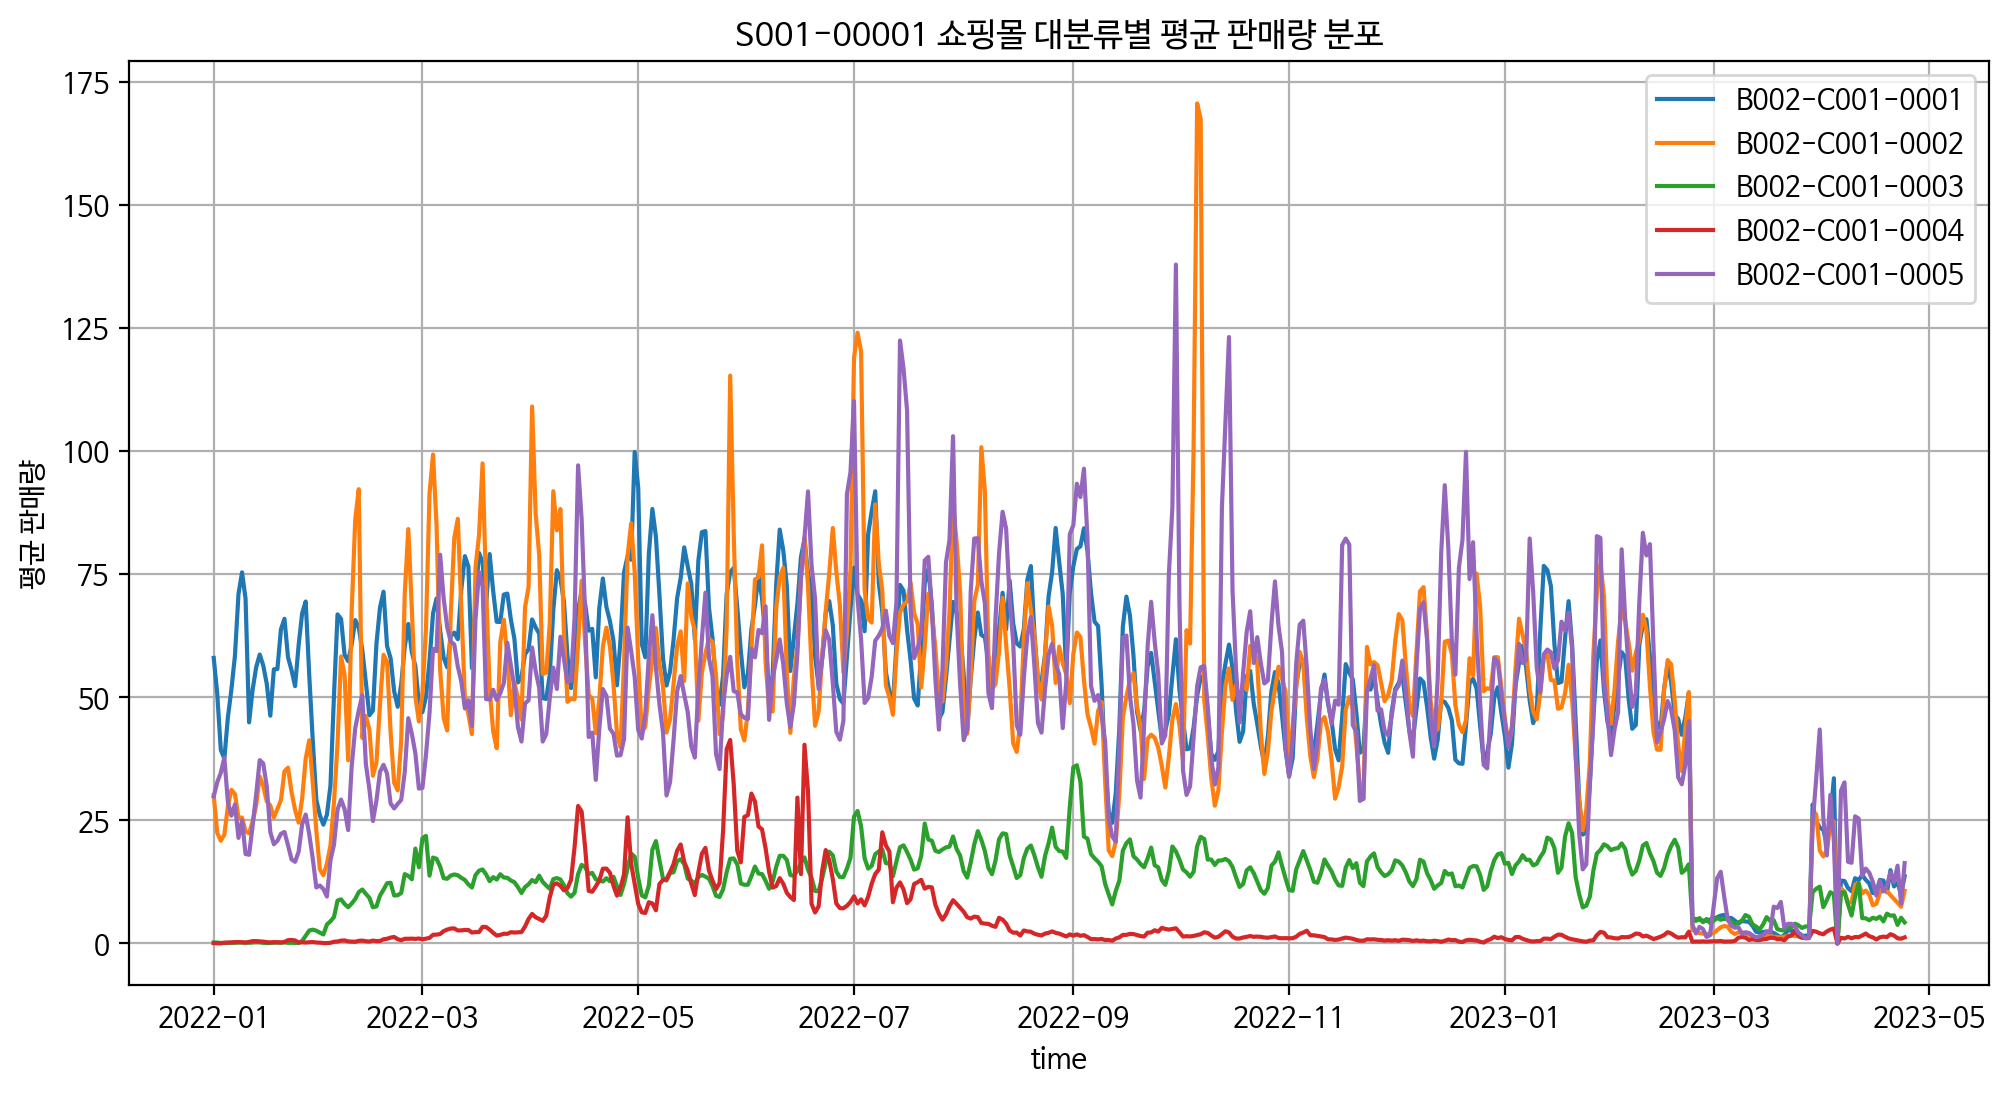

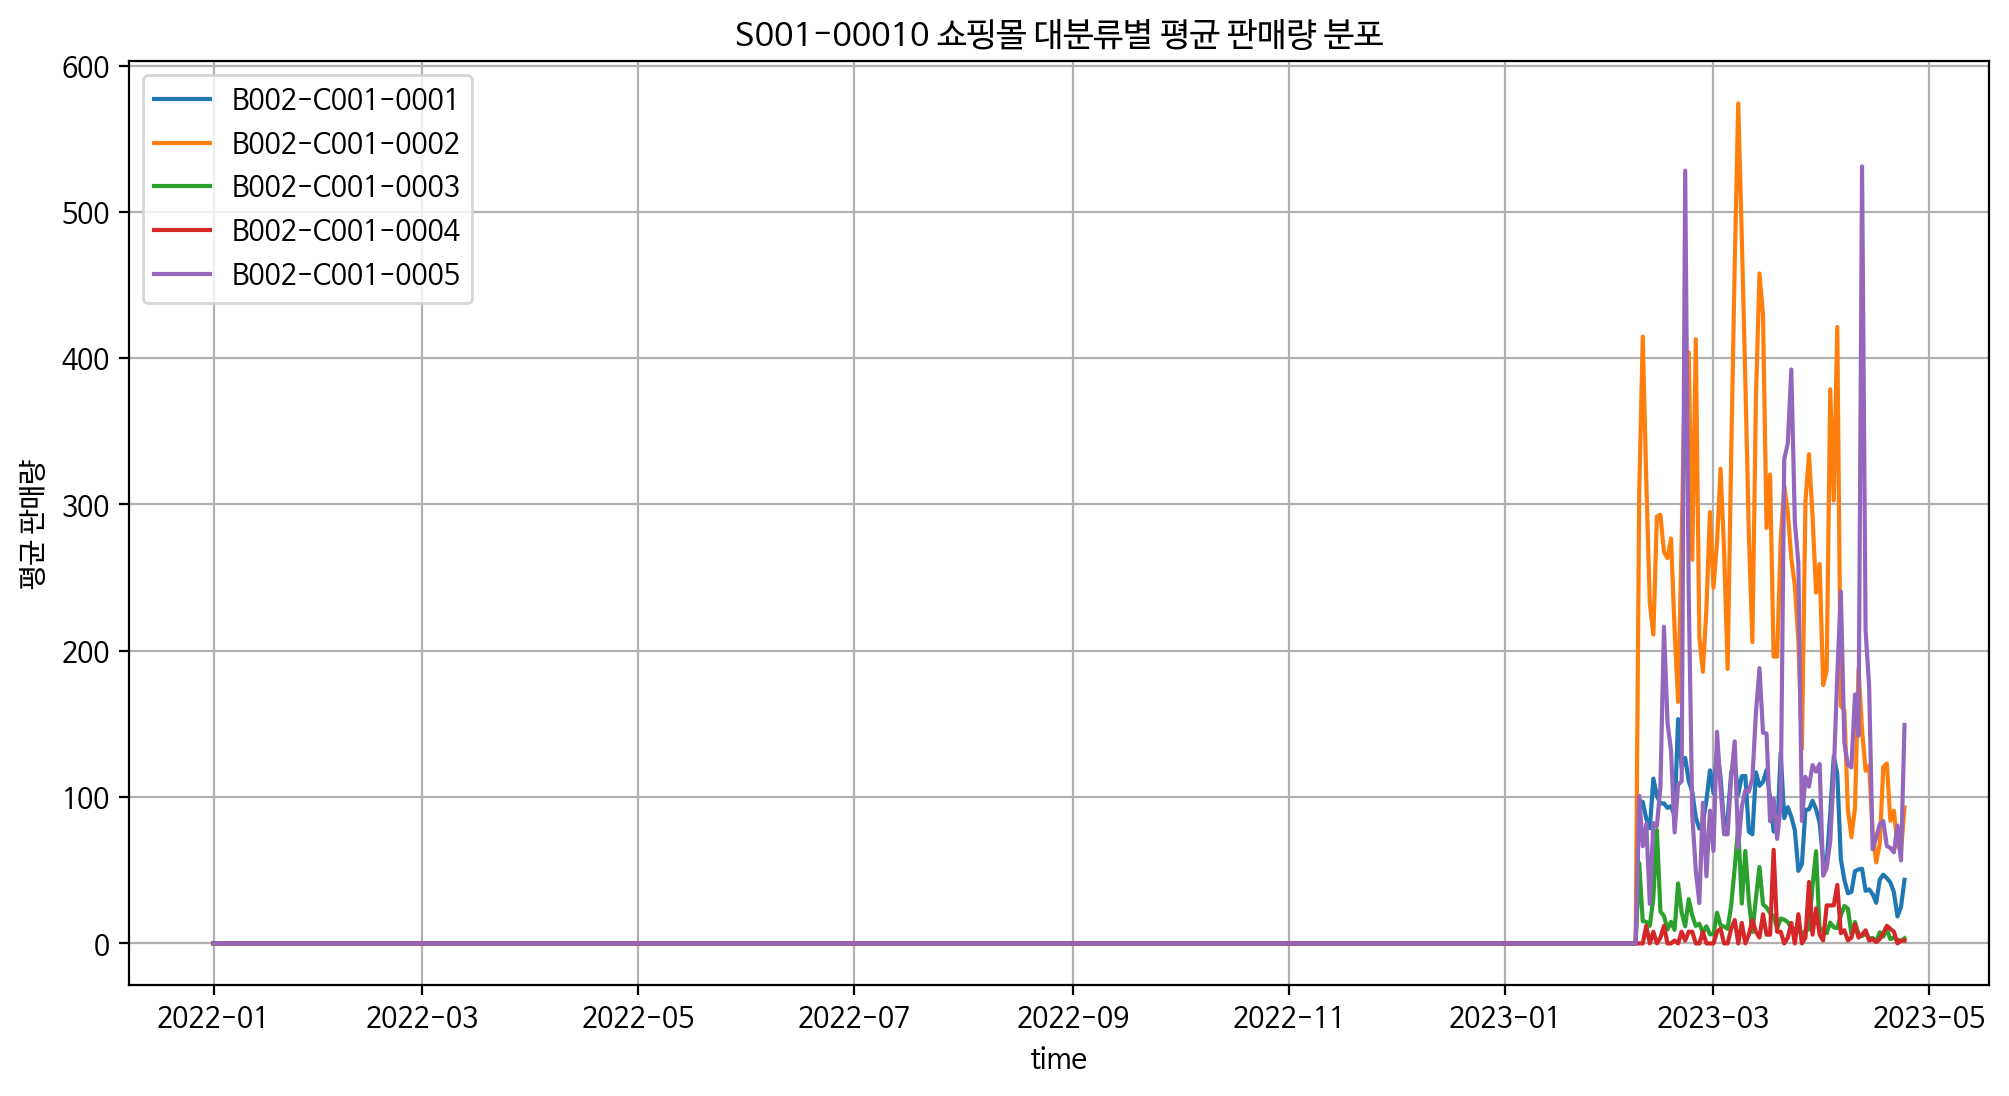

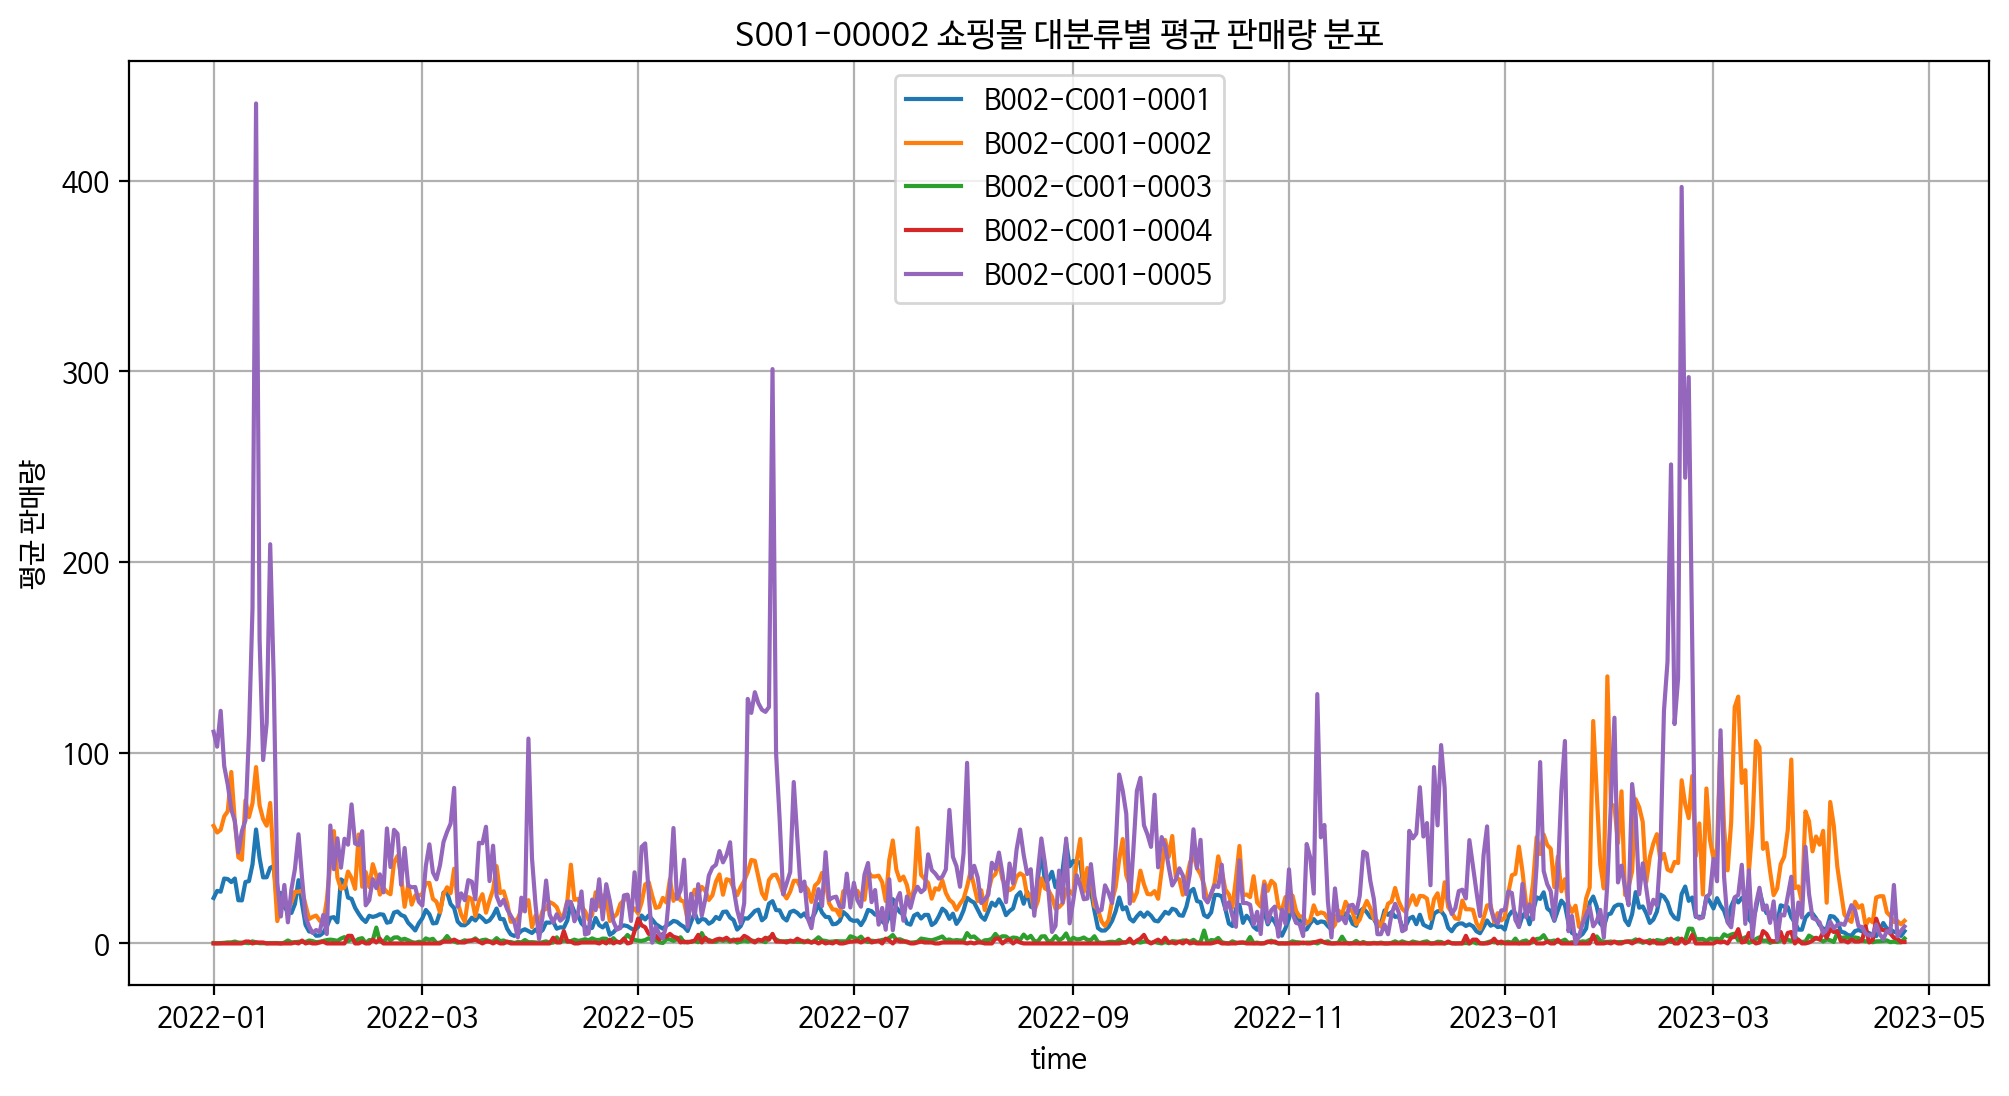

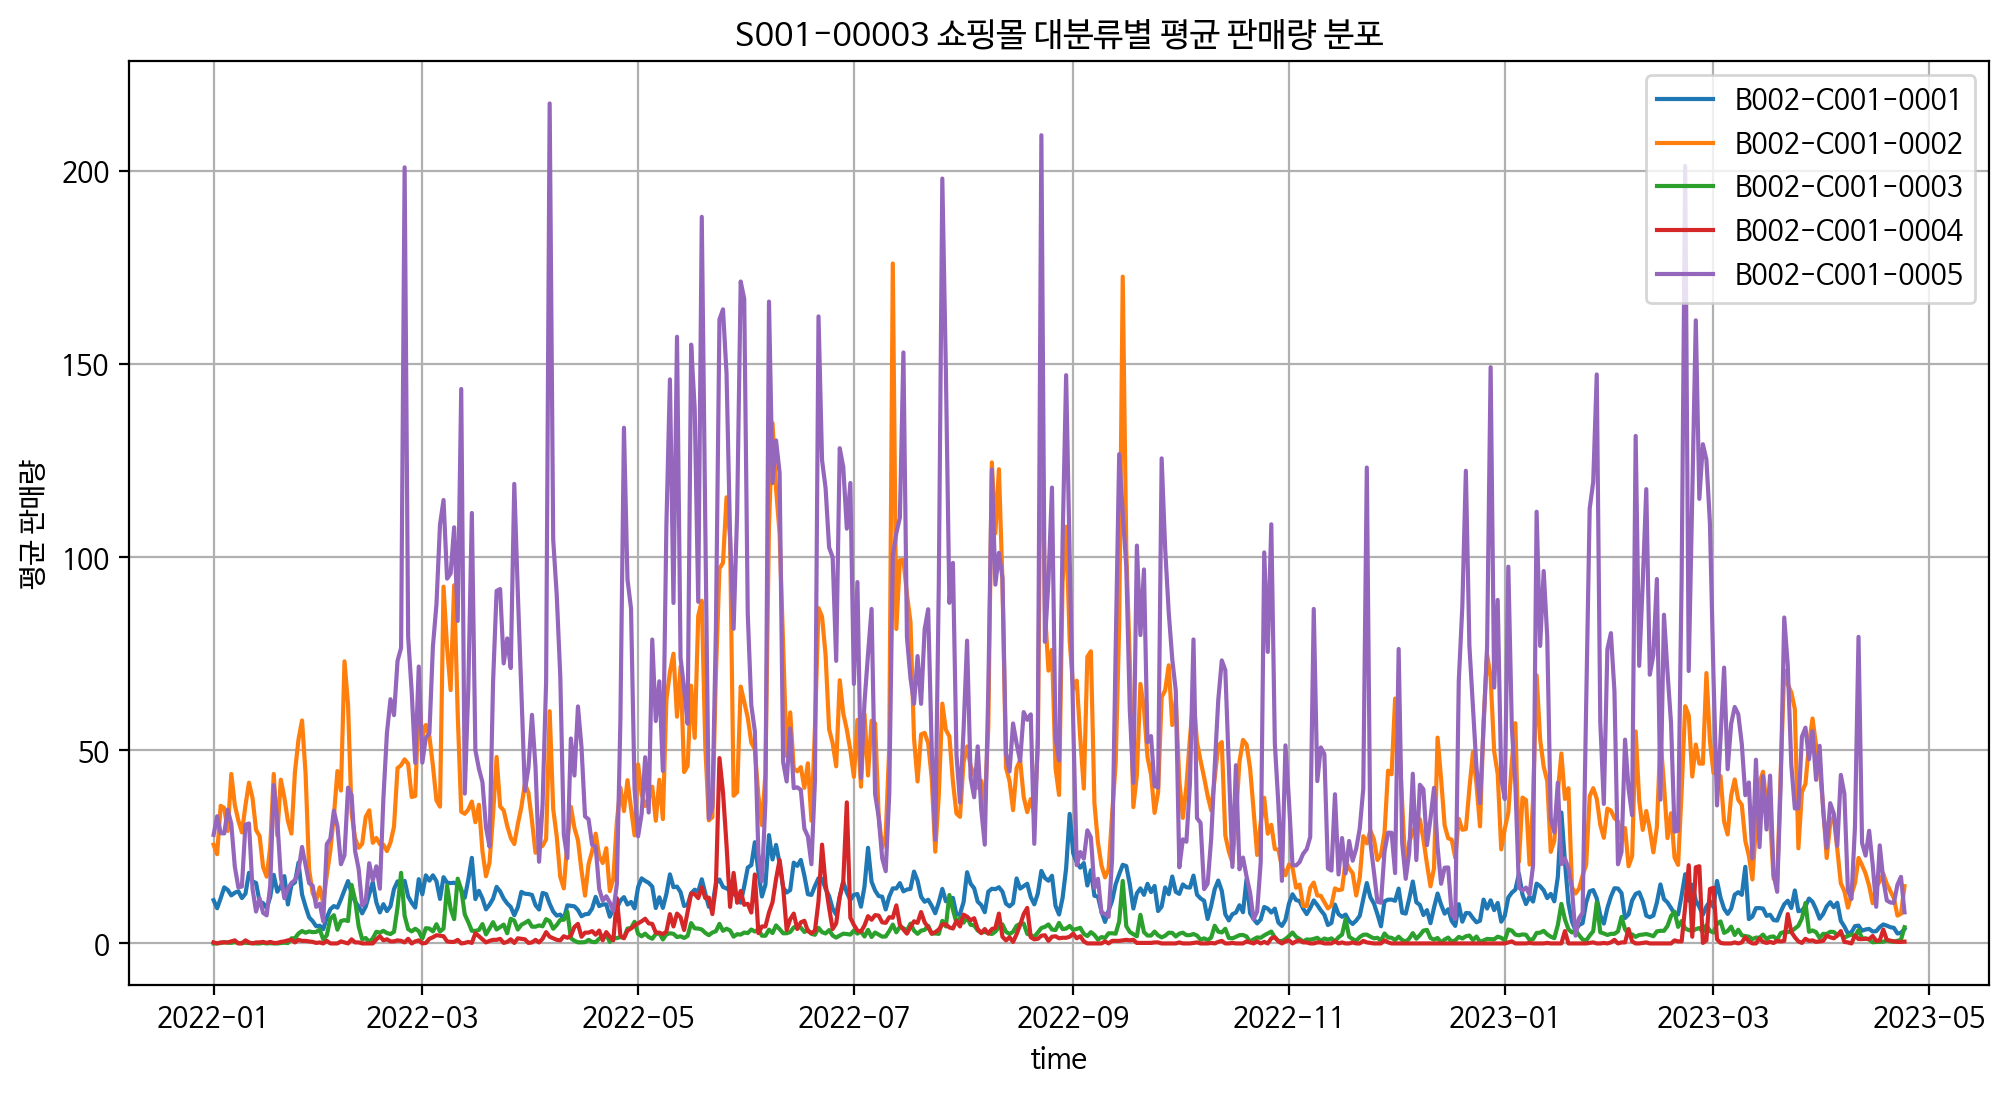

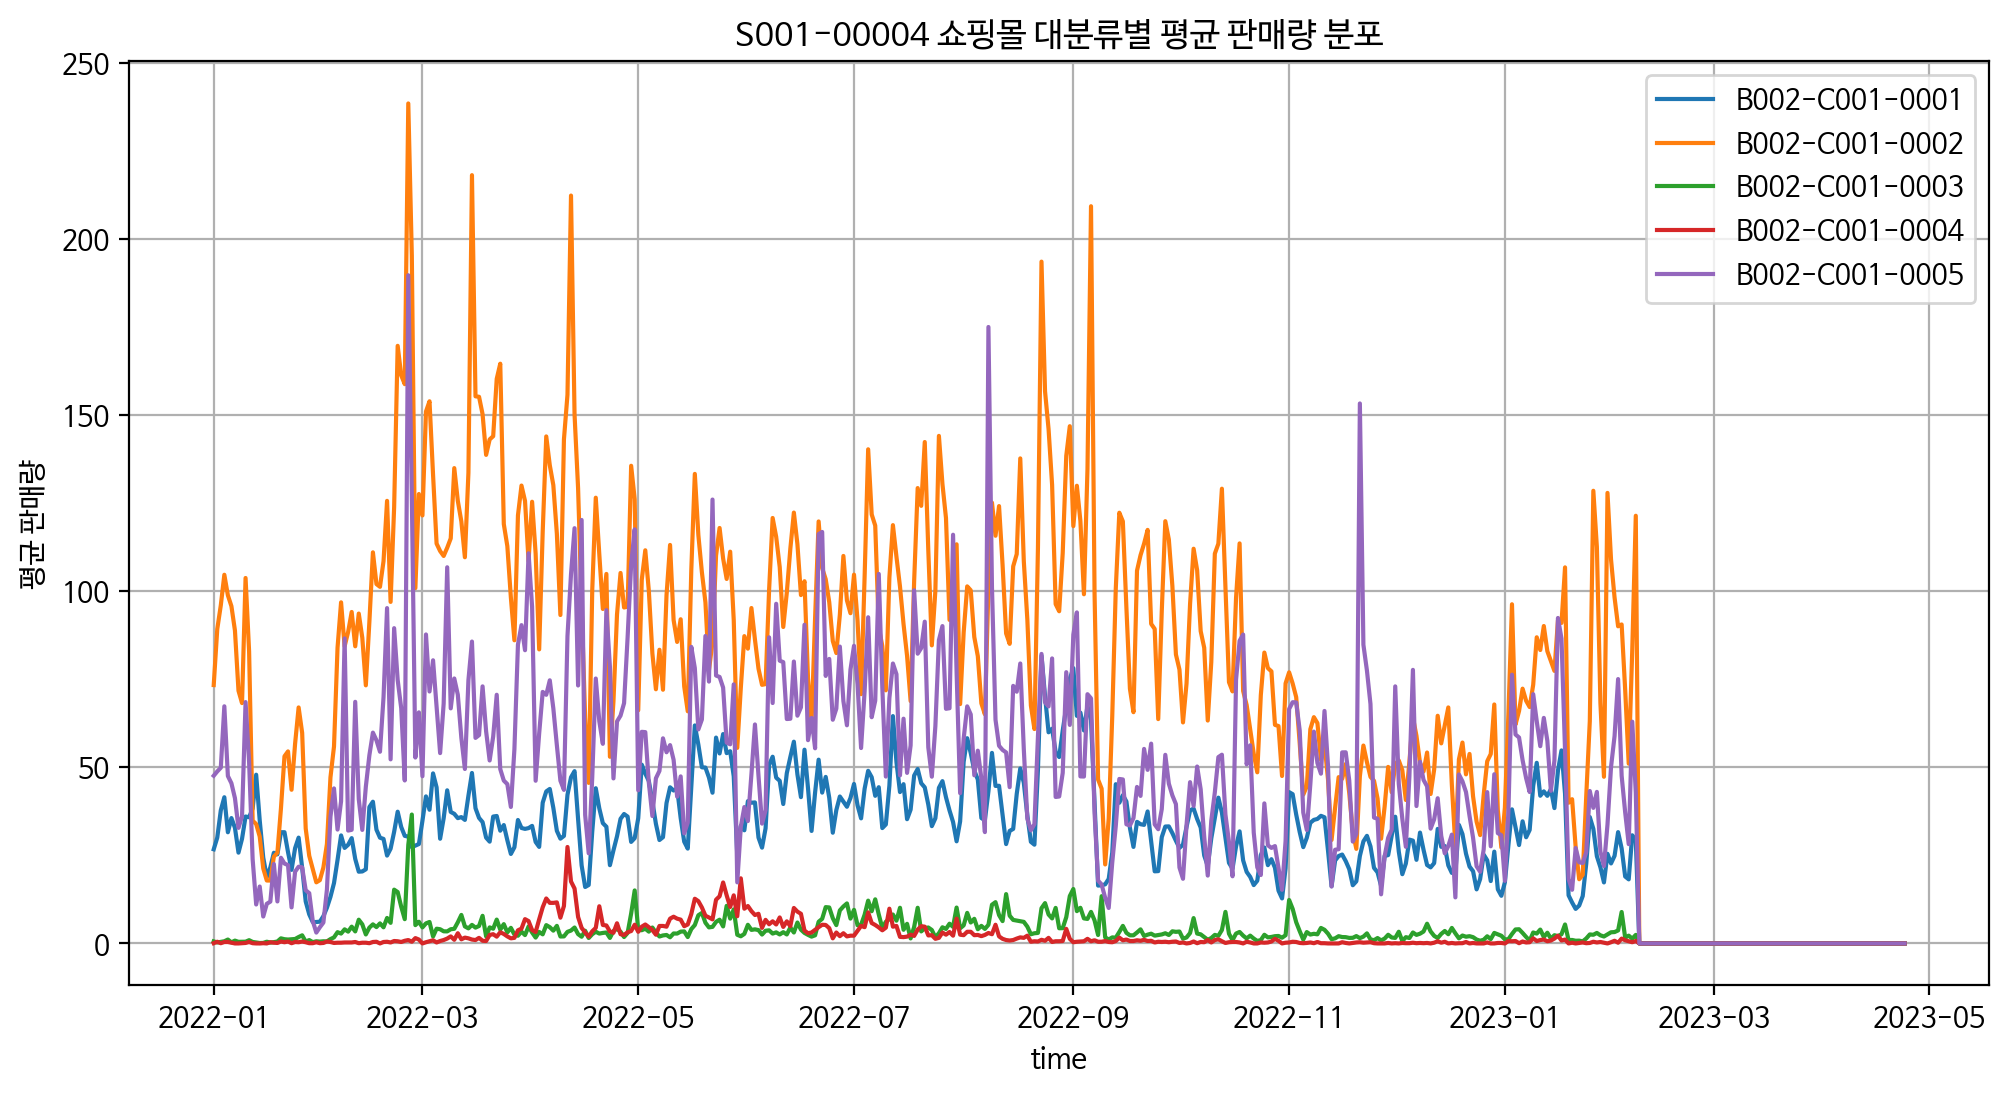

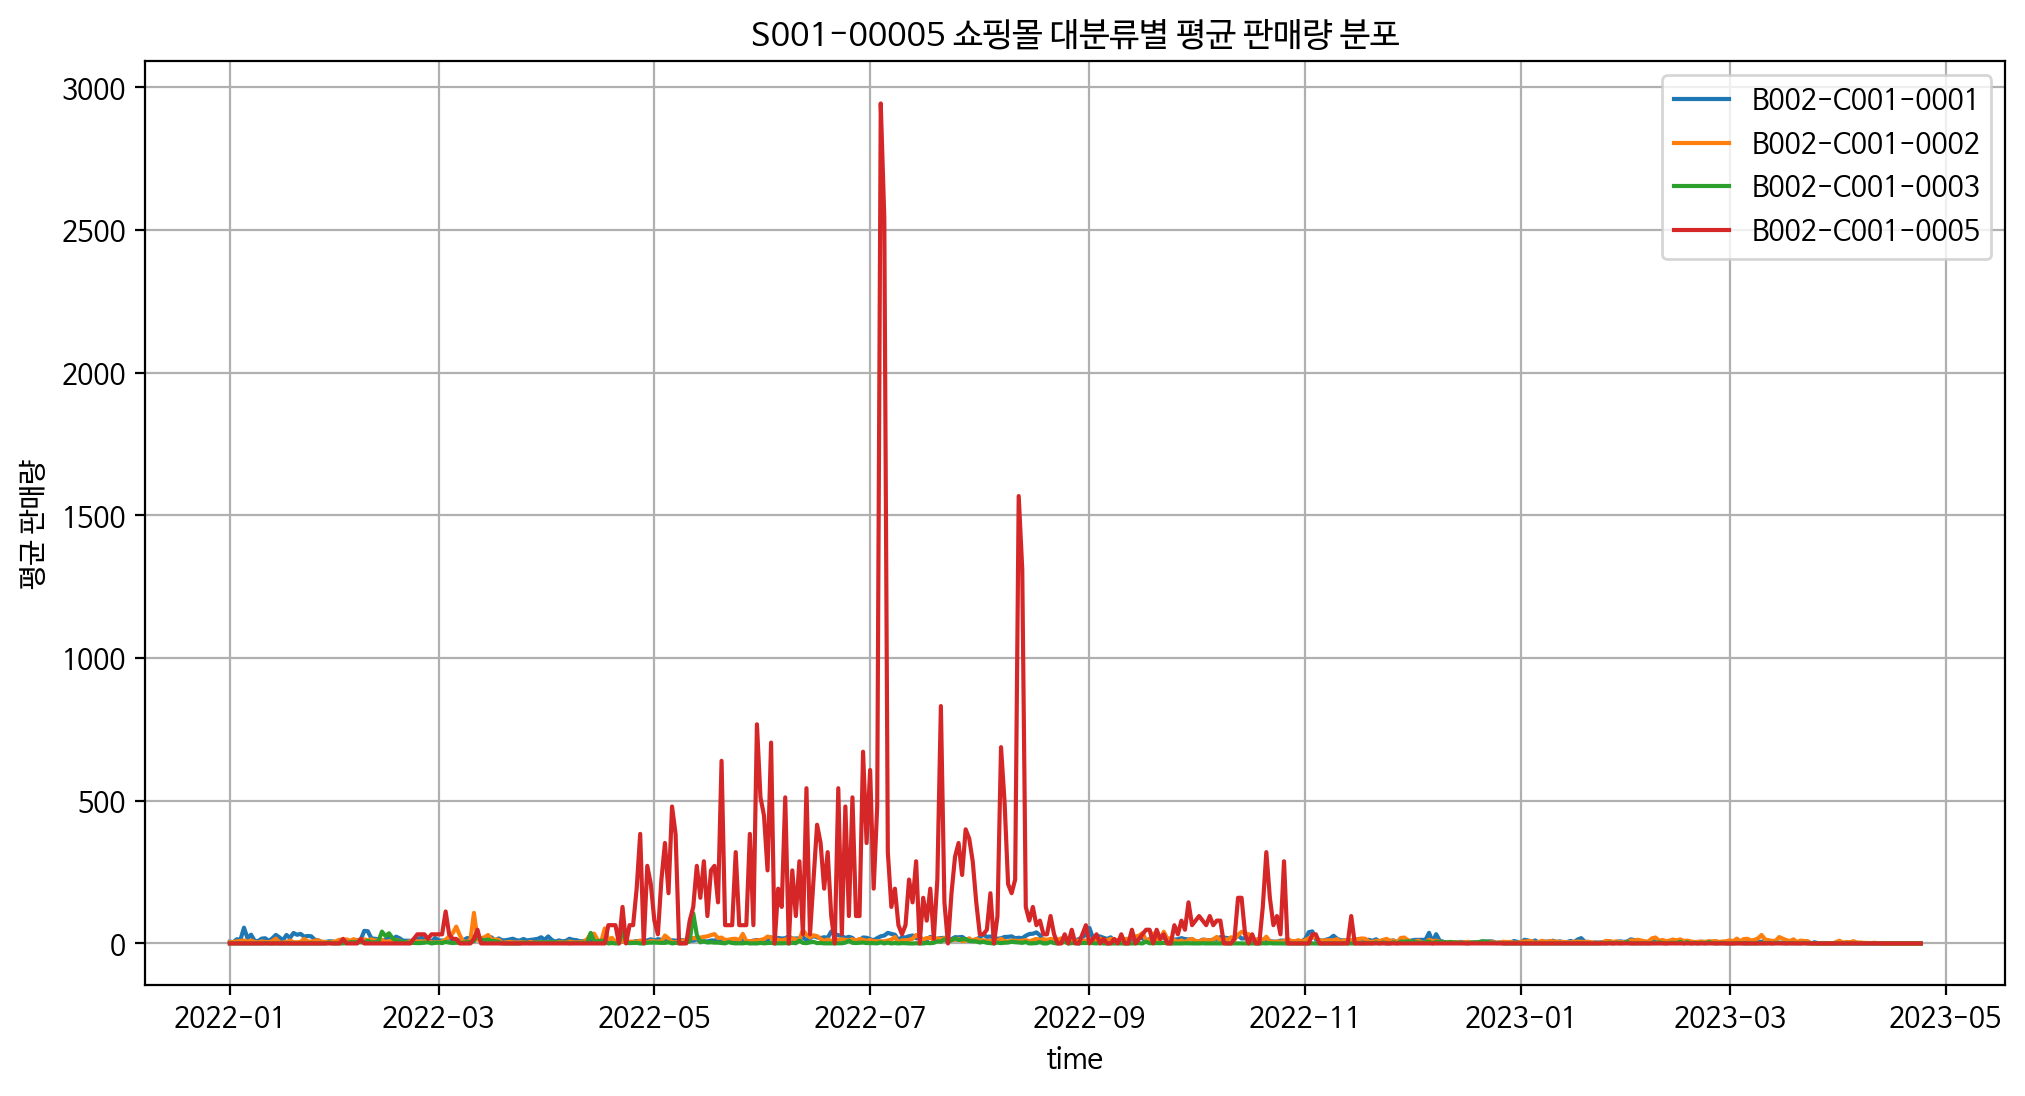

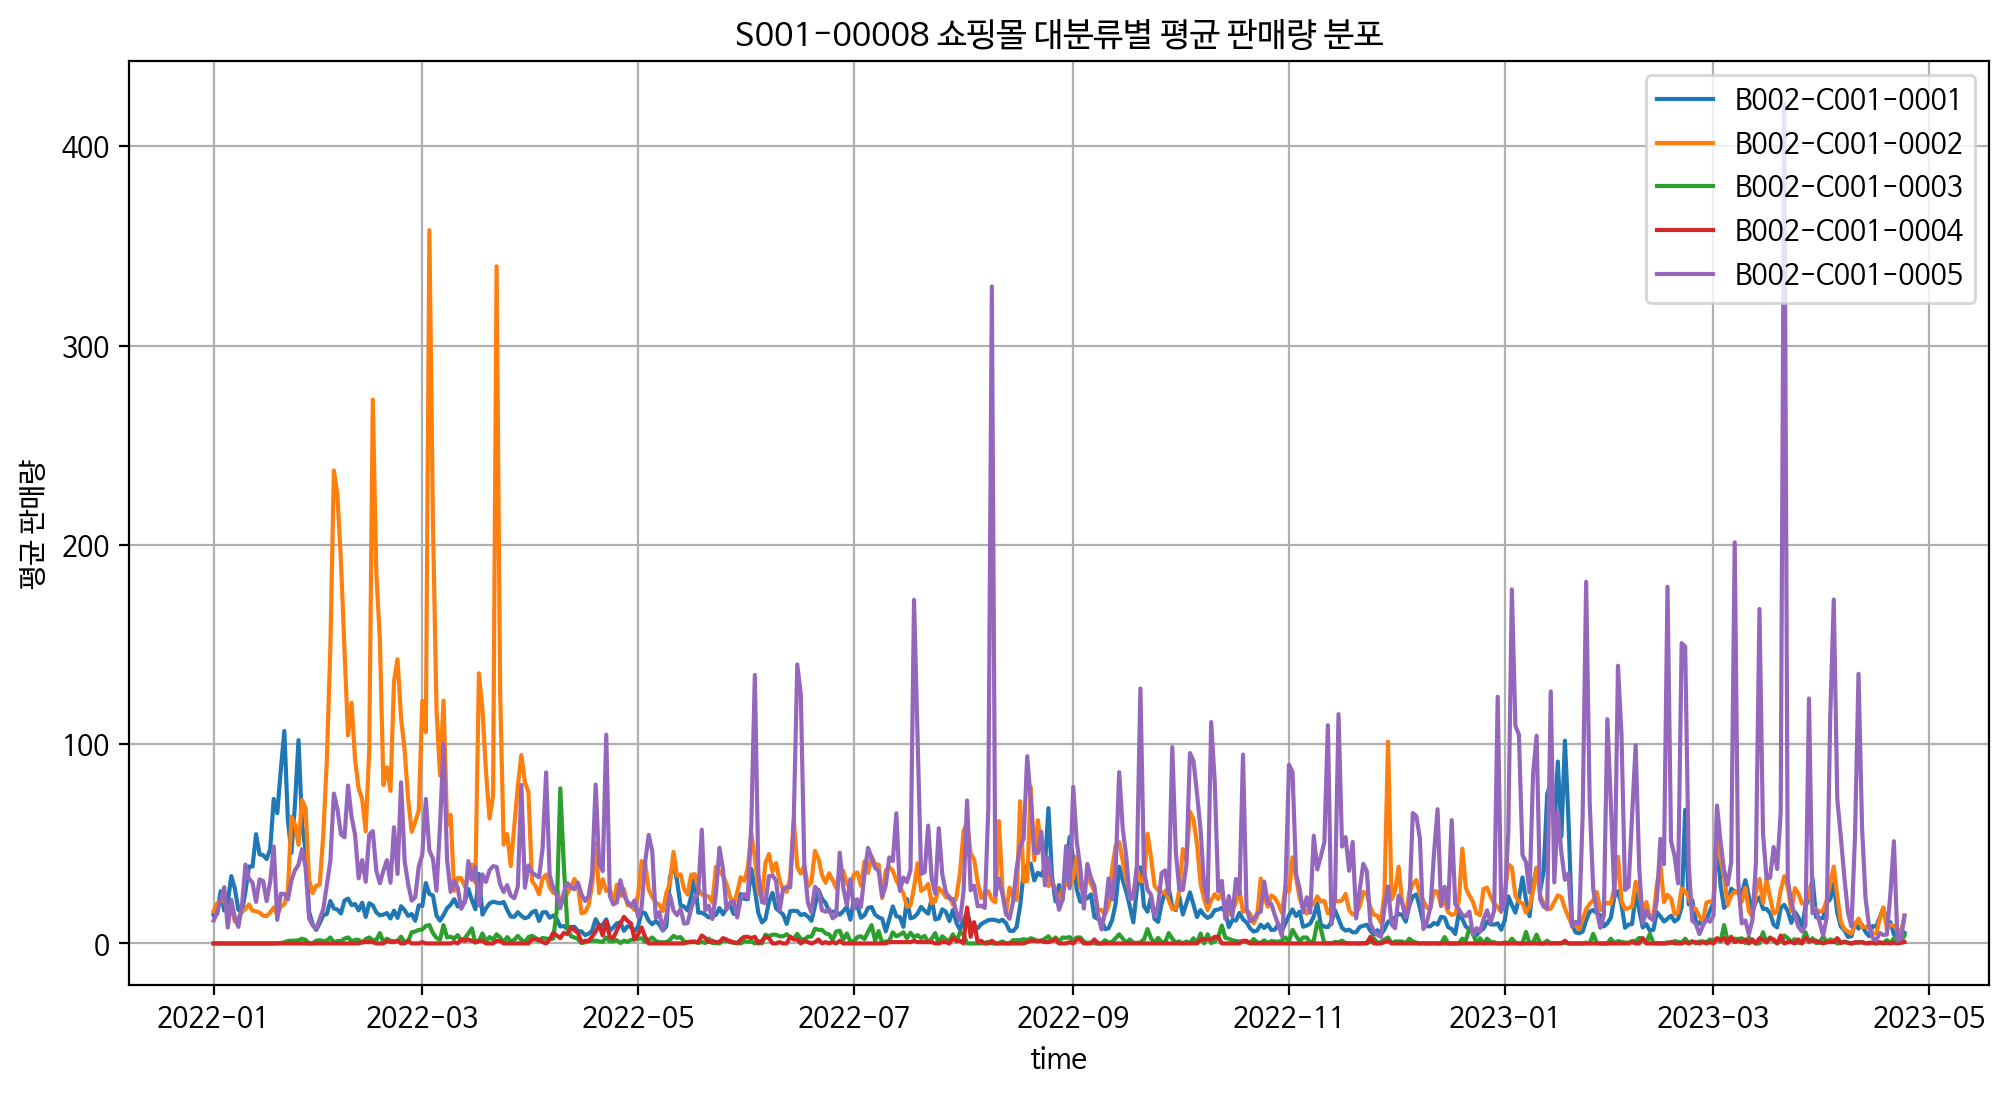

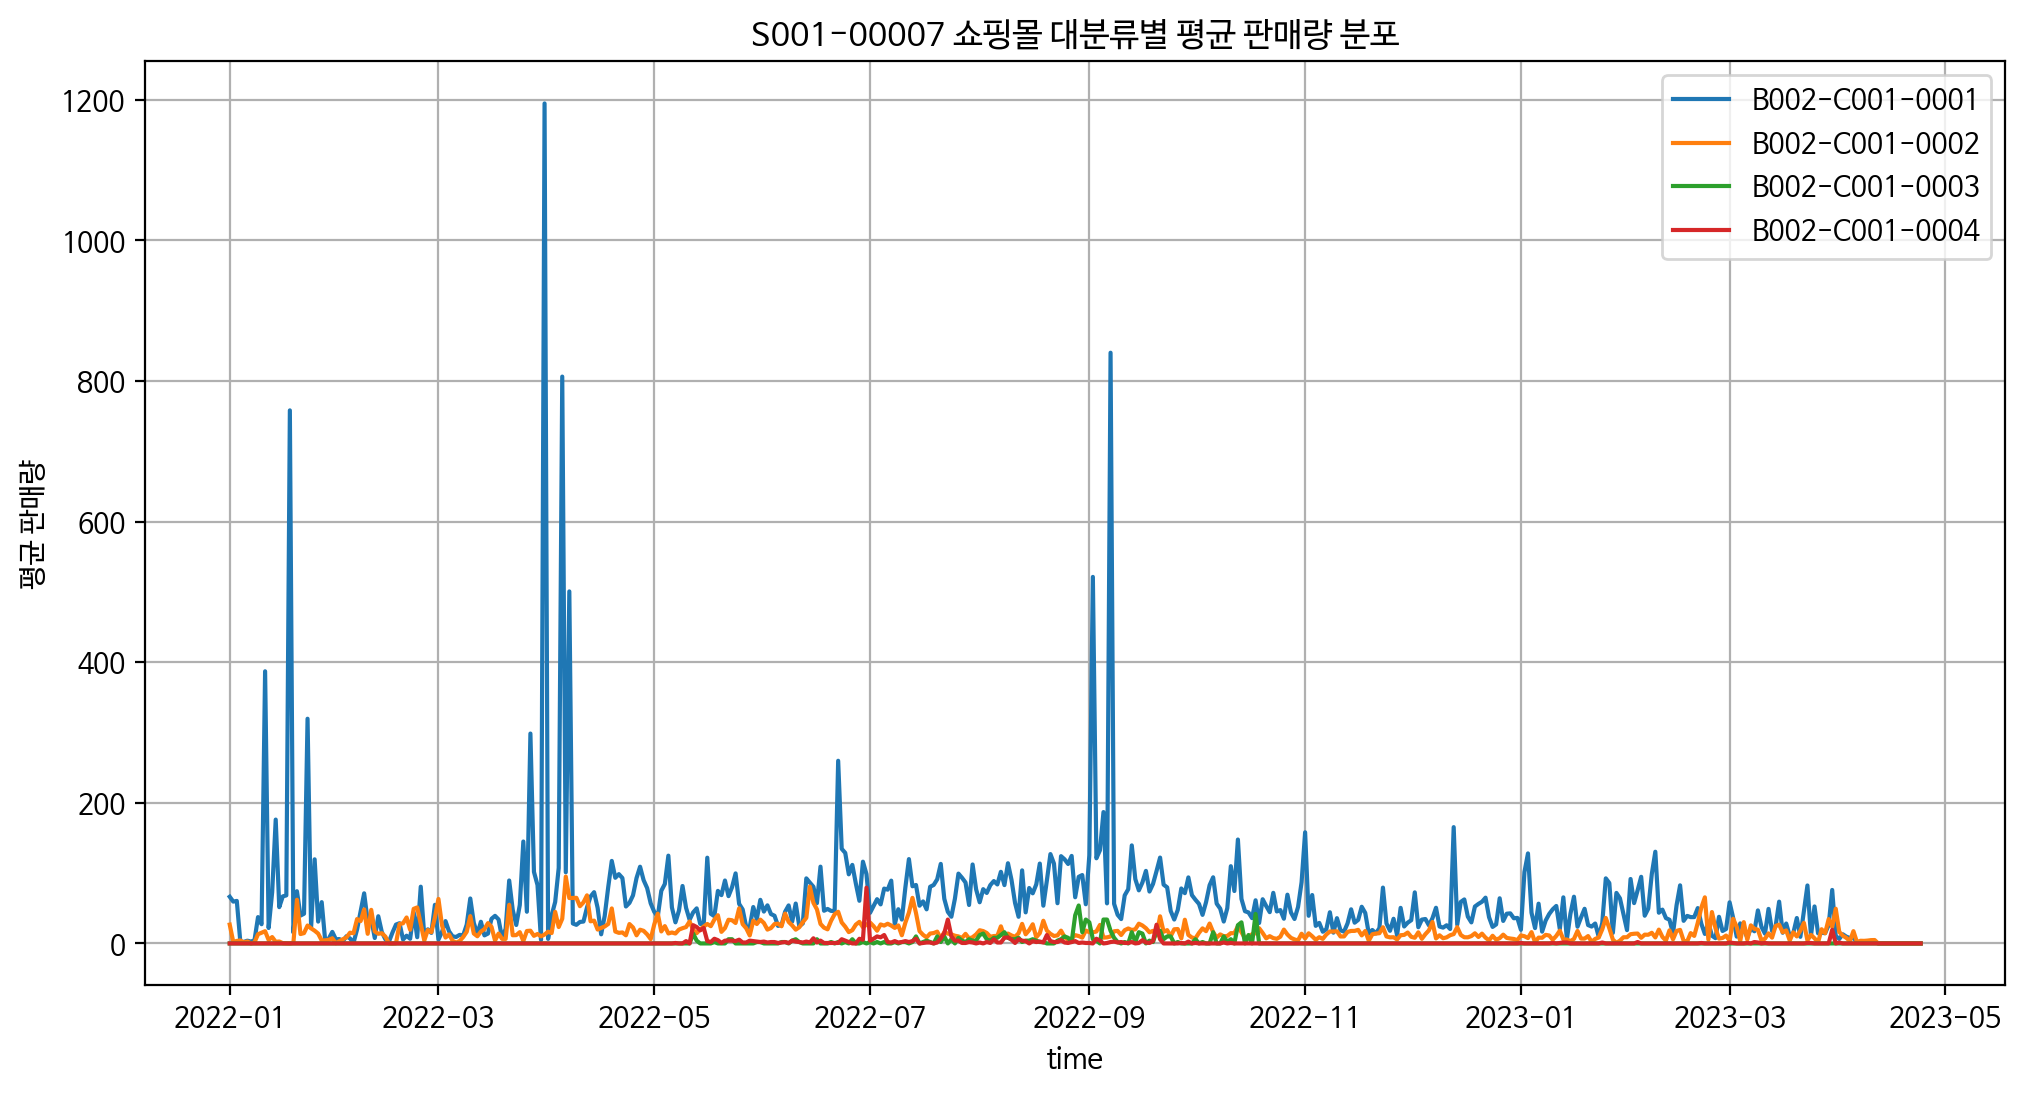

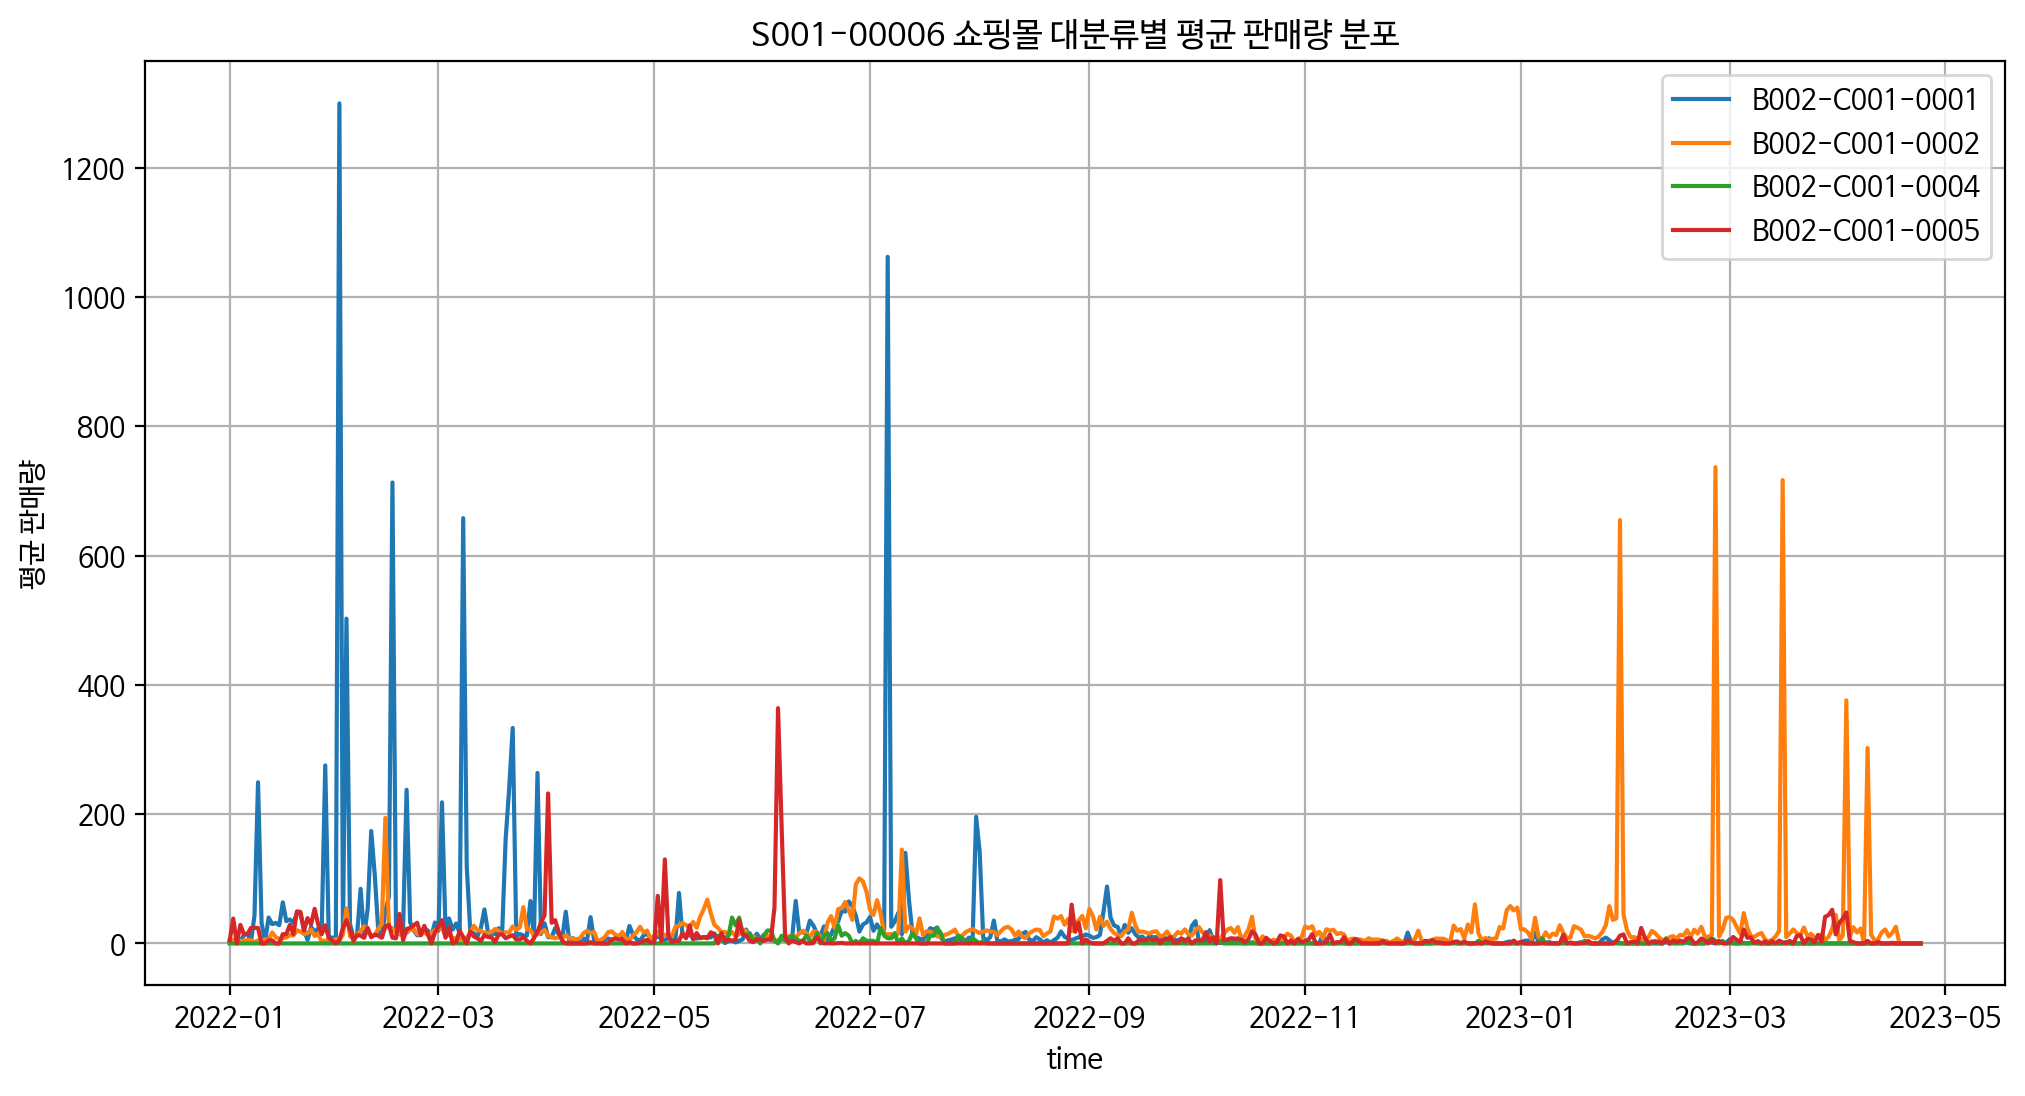

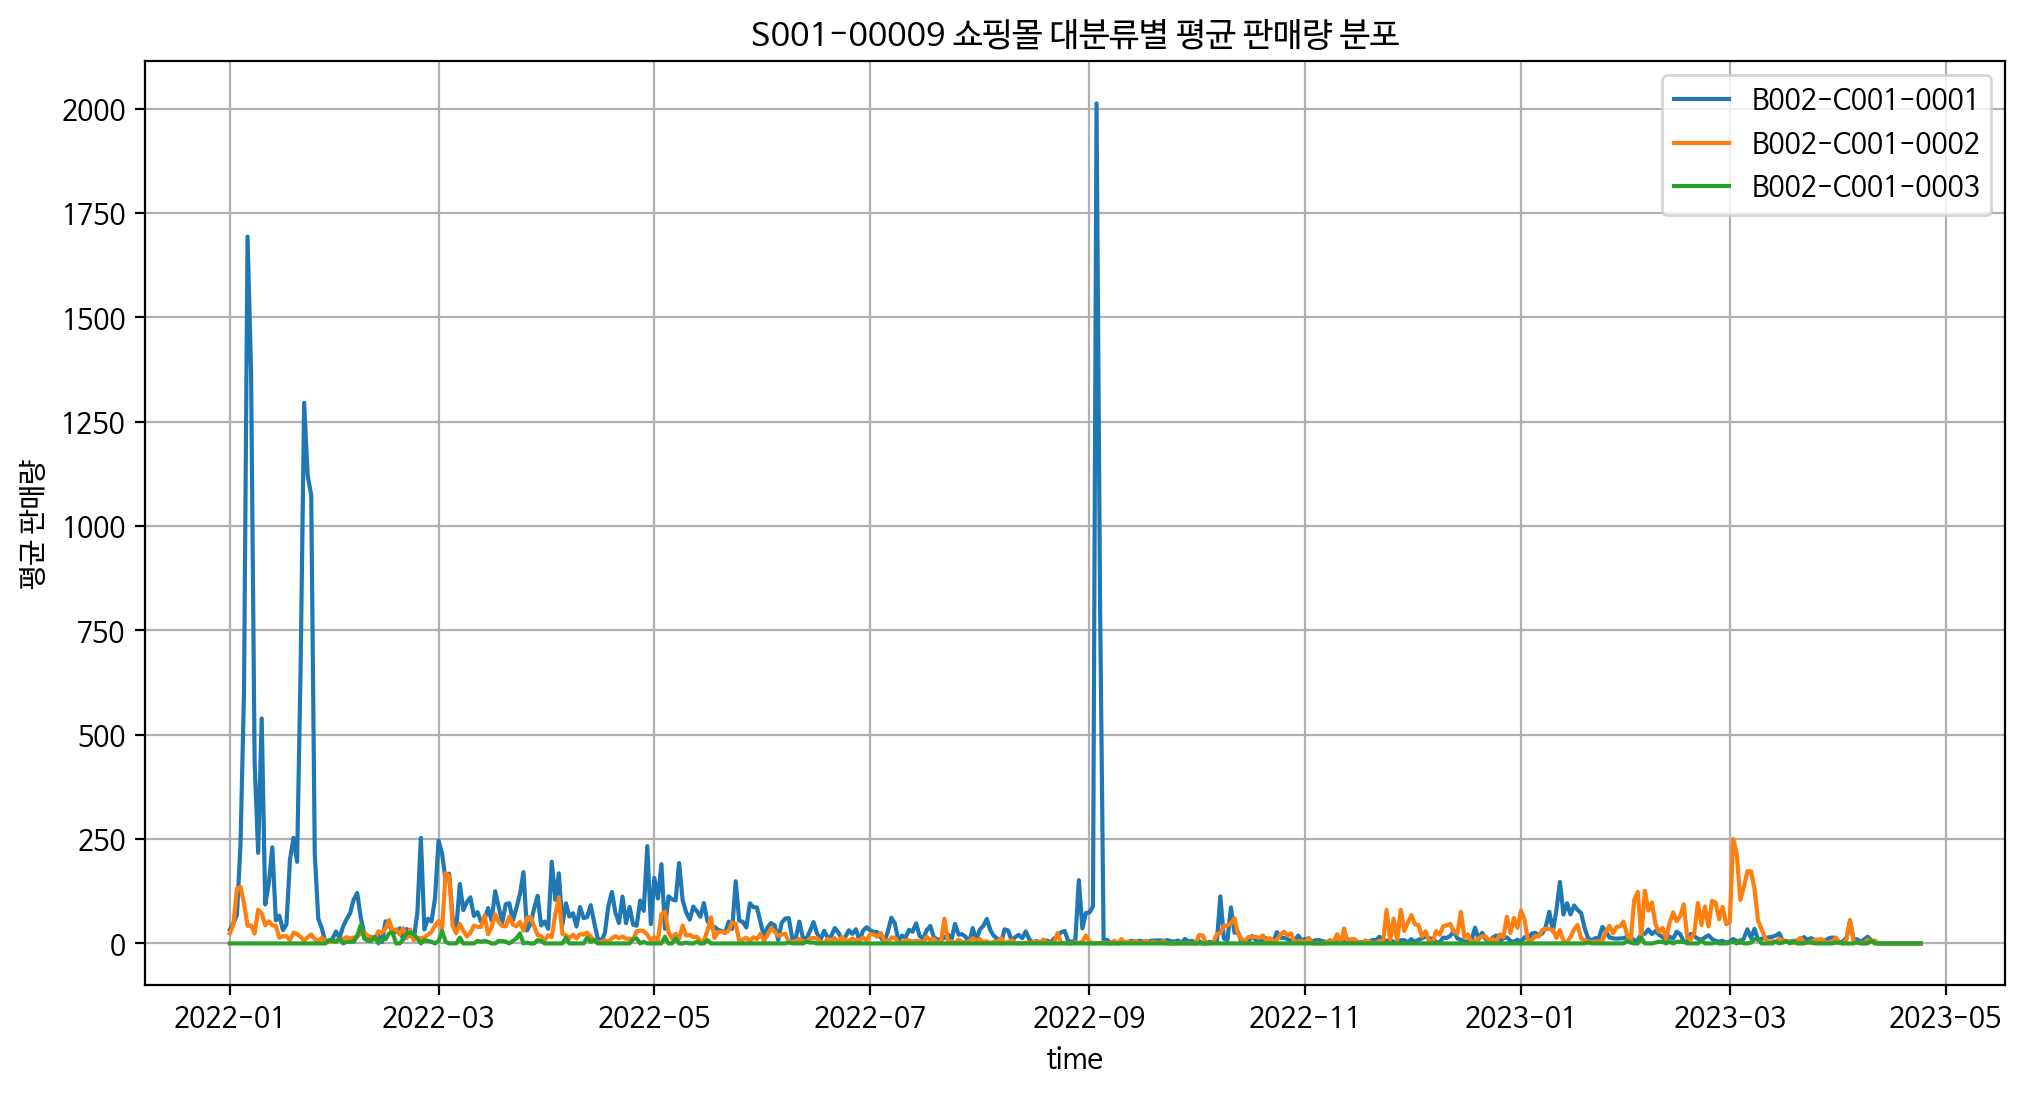

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_avg_sales_by_category_individual(data, category_column, time_column, sell_column):
    # 모든 쇼핑몰 가져오기
    malls = data['mall'].unique()

    # 쇼핑몰별로 그래프 그리기
    for mall in malls:
        # 해당 쇼핑몰에 해당하는 데이터 필터링
        mall_data = data[data['mall'] == mall]

        # 대분류 별 판매량 평균 계산
        avg_sales_by_category = mall_data.groupby([category_column, time_column])[sell_column].mean().reset_index()

        # 대분류 목록 가져오기
        categories = avg_sales_by_category[category_column].unique()

        # 쇼핑몰 이름을 포함한 그래프 제목 설정
        plt.figure(figsize=(12, 6))
        for category in categories:
            category_data = avg_sales_by_category[avg_sales_by_category[category_column] == category]
            plt.plot(category_data[time_column], category_data[sell_column], label=category)

        plt.xlabel(time_column)
        plt.ylabel('평균 판매량')
        plt.title(f'{mall} 쇼핑몰 대분류별 평균 판매량 분포')
        plt.legend()
        plt.grid()
        plt.show()

# 모든 쇼핑몰에 대해 함수 호출
plot_avg_sales_by_category_individual(train, 'Big_cat', 'time', 'sell')


# ARIMA와 Prophet 앙상블 Model

In [ ]:
# 원하는 10개의 제품 ID를 선택
fixed_product_ids = [1, 2, 3, 8, 14, 20, 9, 15, 51, 10, 12, 16, 827, 1533, 1688, 607, 4042, 9081, 1732, 1919, 4880, 401, 532, 550, 1734, 8427, 11692, 210, 221, 252]  # 원하는 제품 ID를 명시적으로 지정하세요

# train 데이터프레임을 준비하세요.
train.set_index('time', inplace=True)

forecast_range = pd.date_range(start='2023-04-01', periods=25)

all_forecasts = {}

# 예측과 실제 값을 저장할 데이터프레임 생성
forecast_df = pd.DataFrame(index=forecast_range)

for product in fixed_product_ids:  # 랜덤 대신 고정된 제품 ID를 순회합니다.
    ts = train[train['ID'] == product]['sell']

    model = ARIMA(ts, order=(5, 1, 0))
    model_fit = model.fit()
    forecast_arima = model_fit.forecast(steps=25)

    # Prophet 모델 피팅
    x_df = pd.DataFrame()
    x_df['ds'] = ts.index
    x_df['y'] = ts.values

    prophet = Prophet(seasonality_mode='additive',
                      yearly_seasonality=False,
                      weekly_seasonality='auto', daily_seasonality=False,
                      changepoint_prior_scale=0.5)
    prophet.add_country_holidays(country_name='KR')
    prophet.add_seasonality(name='2_week', period=14, fourier_order=5)
    prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)

    prophet.fit(x_df)

    future_data = prophet.make_future_dataframe(periods=25, freq='D')

    forecast_prophet = prophet.predict(future_data)

    # Prophet 모델의 예측 값을 ARIMA 모델의 예측 길이에 맞추기
    forecast_prophet = forecast_prophet[forecast_prophet['ds'].isin(forecast_range)]

    # ARIMA와 Prophet 모델의 예측 값을 최종 예측으로 조합
    max_forecast = np.maximum(forecast_arima, forecast_prophet['yhat'].values)
    max_forecast[max_forecast < 0] = 0

    all_forecasts[product] = max_forecast

    # # 각 제품에 대한 예측 그래프 그리기
    # plt.figure(figsize=(10, 4))
    # plt.plot(forecast_range, max_forecast, label=f'Product {product} Forecast')
    # plt.plot(ts.index, ts.values, label=f'Product {product} Actual', linestyle='--', color='black')
    # plt.xlabel('Date')
    # plt.ylabel('Sales')
    # plt.title(f'Sales Forecast vs. Actual Sales - Product {product}')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(forecast_range, max_forecast, label=f'Product {product} Max Forecast')
    plt.plot(forecast_range, forecast_arima, label=f'Product {product} ARIMA Forecast', linestyle='--')
    plt.plot(forecast_range, forecast_prophet['yhat'].values, label=f'Product {product} Prophet Forecast', linestyle='--')
    plt.plot(ts.index, ts.values, label=f'Product {product} Actual', linestyle='--', color='black')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Sales Forecast vs. Actual Sales - Product {product}')
    plt.legend()
    plt.grid(True)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# 과거 60일 데이터 보고 아리마 결정

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbcgk903x/wbrp0gbv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbcgk903x/huz6l1__.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29259', 'data', 'file=/tmp/tmpbcgk903x/wbrp0gbv.json', 'init=/tmp/tmpbcgk903x/huz6l1__.json', 'output', 'file=/tmp/tmpbcgk903x/prophet_modelo55iu3jx/prophet_model-20230916122417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


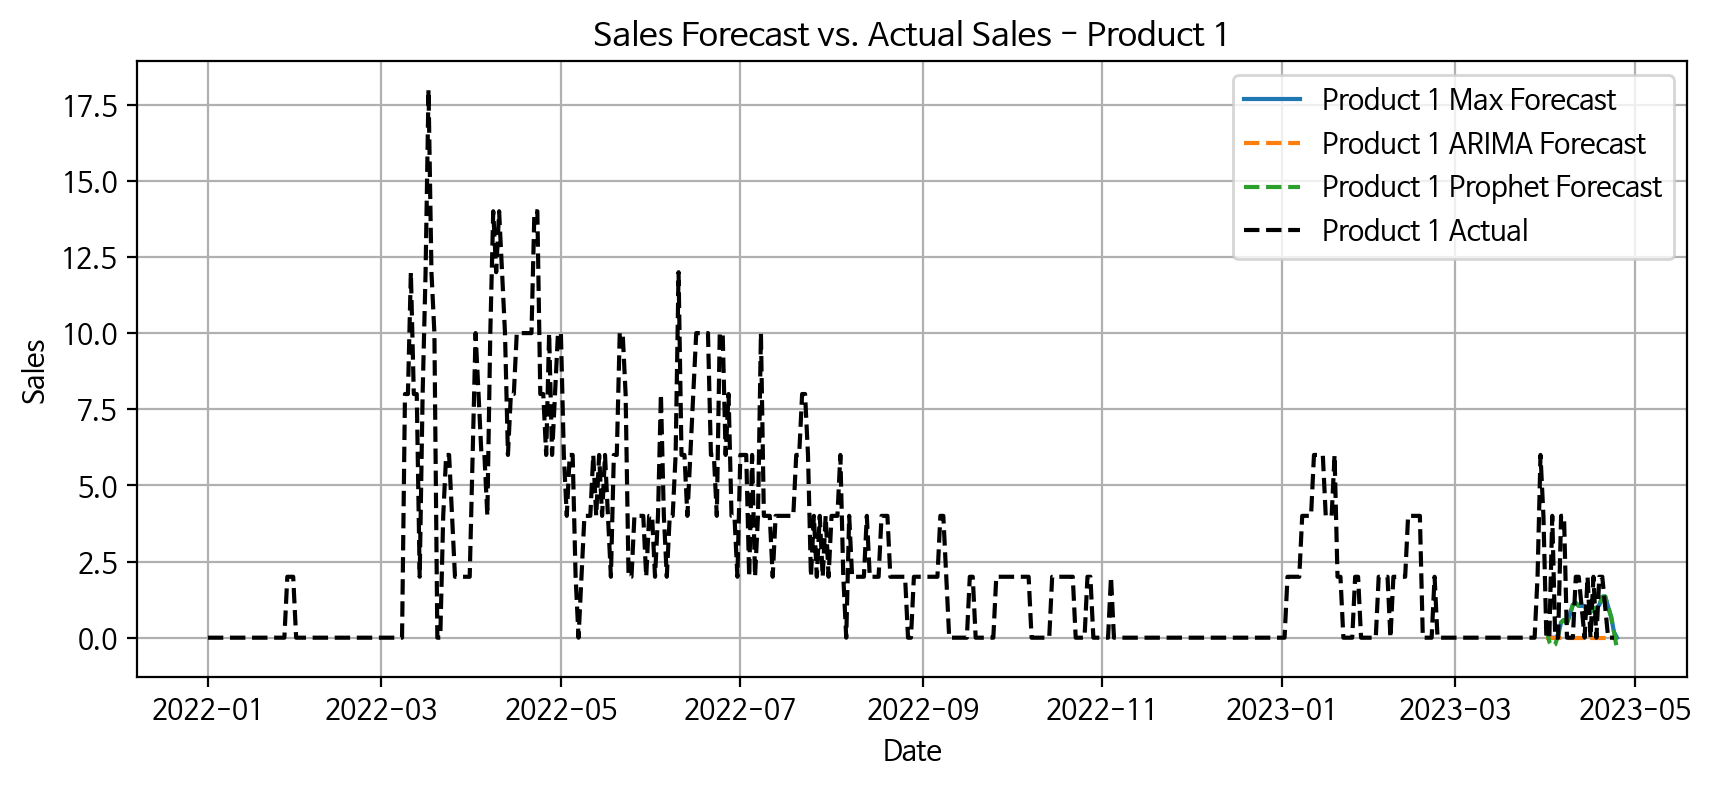

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

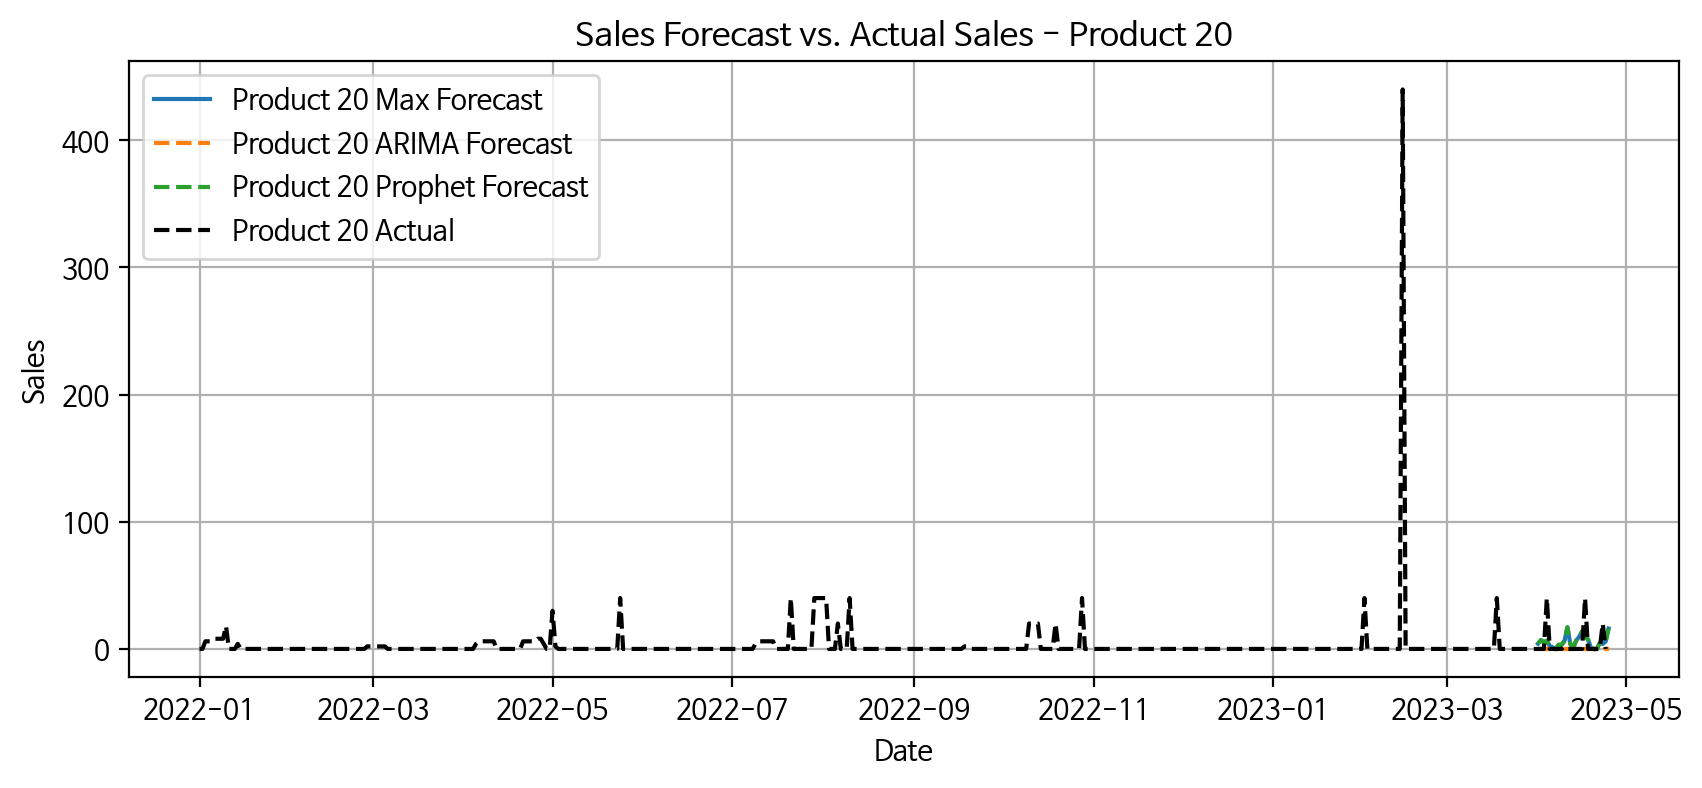

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

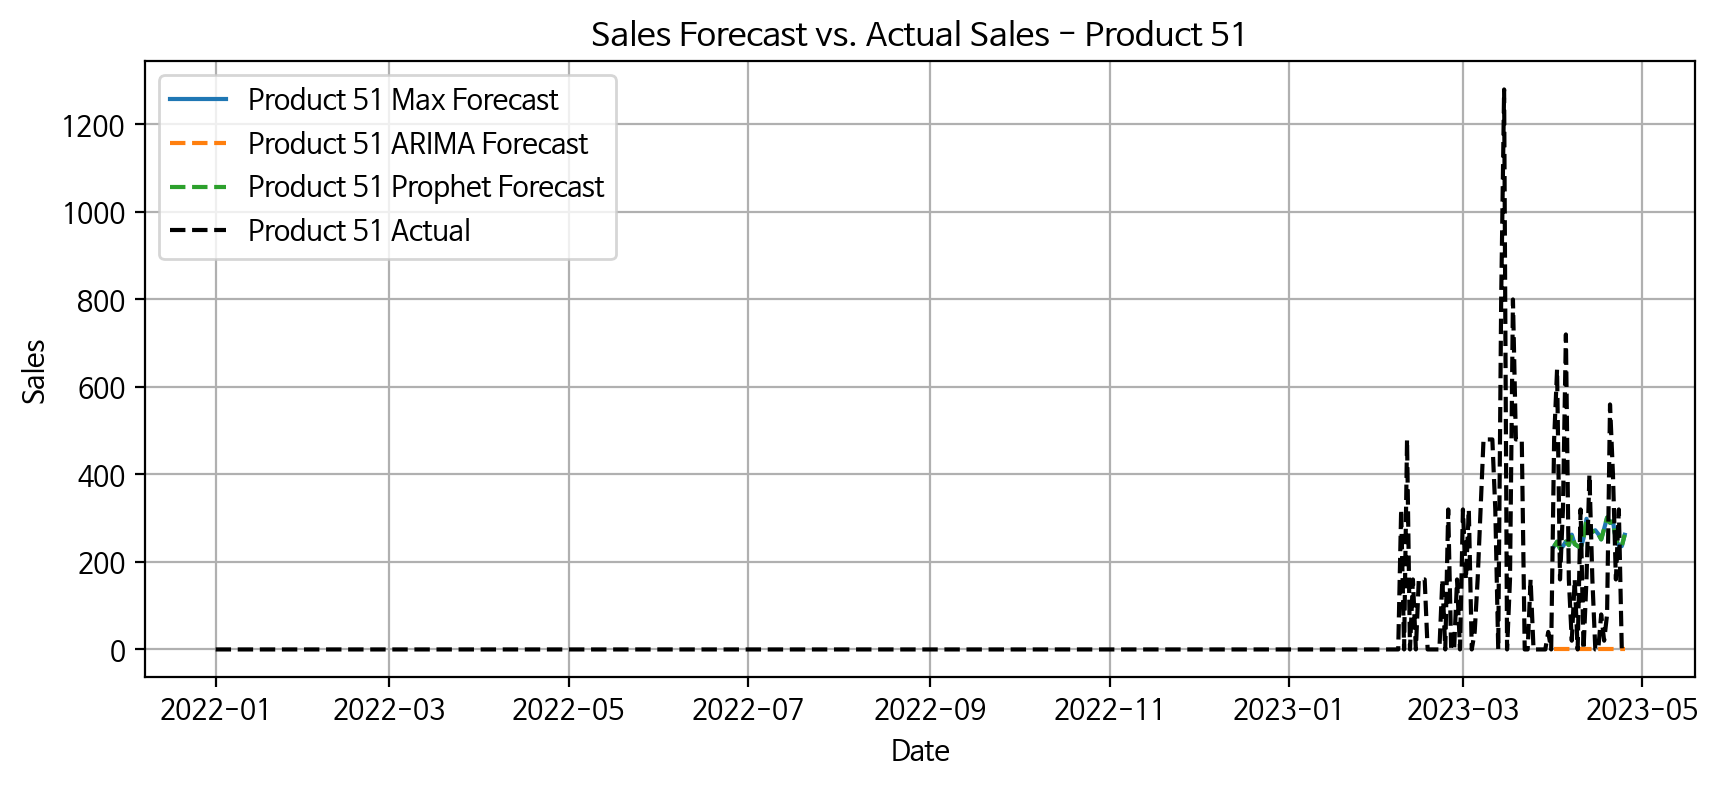

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

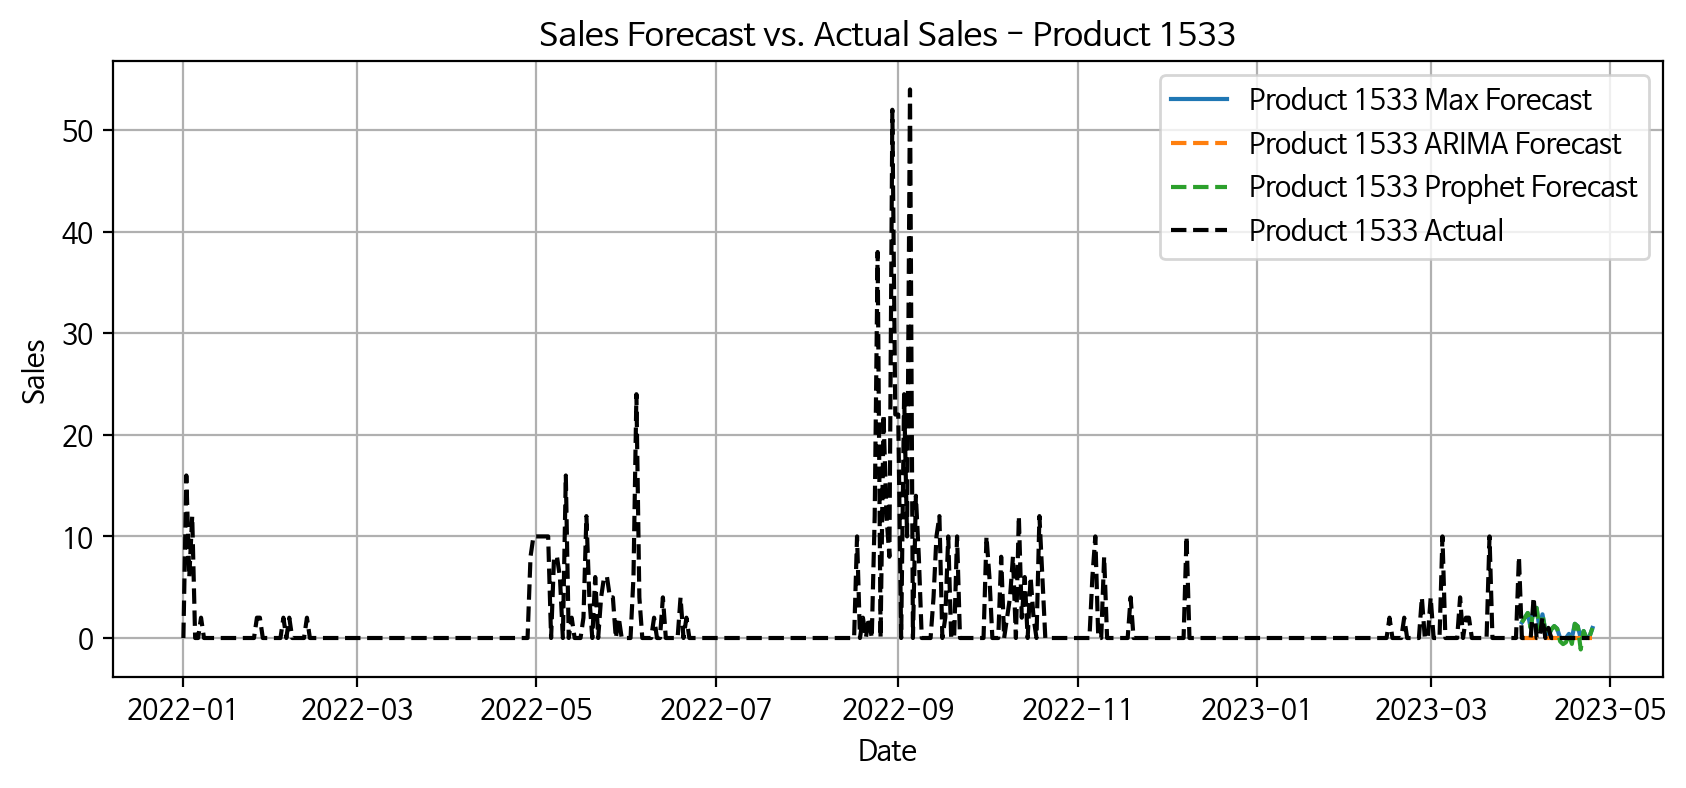

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbcgk903x/bbd04s67.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbcgk903x/shj51h_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14442', 'data', 'file=/tmp/tmpbcgk903x/bbd04s67.json', 'init=/tmp/tmpbcgk903x/shj51h_k.json', 'output', 'file=/tmp/tmpbcgk903x/prophet_model0o1aks4p/prophet_model-20230916122422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


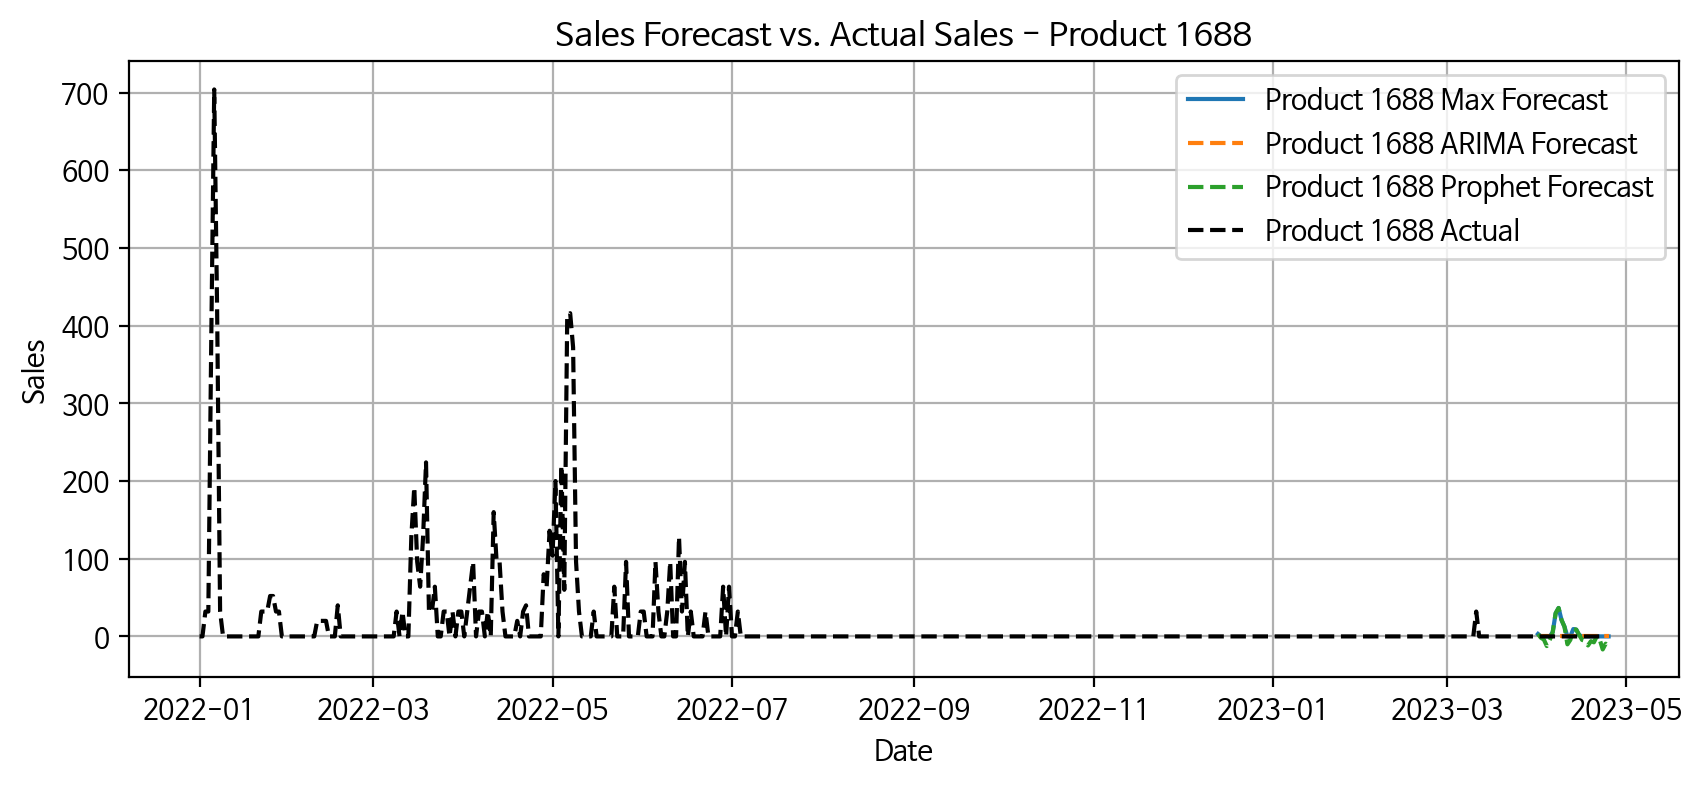

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

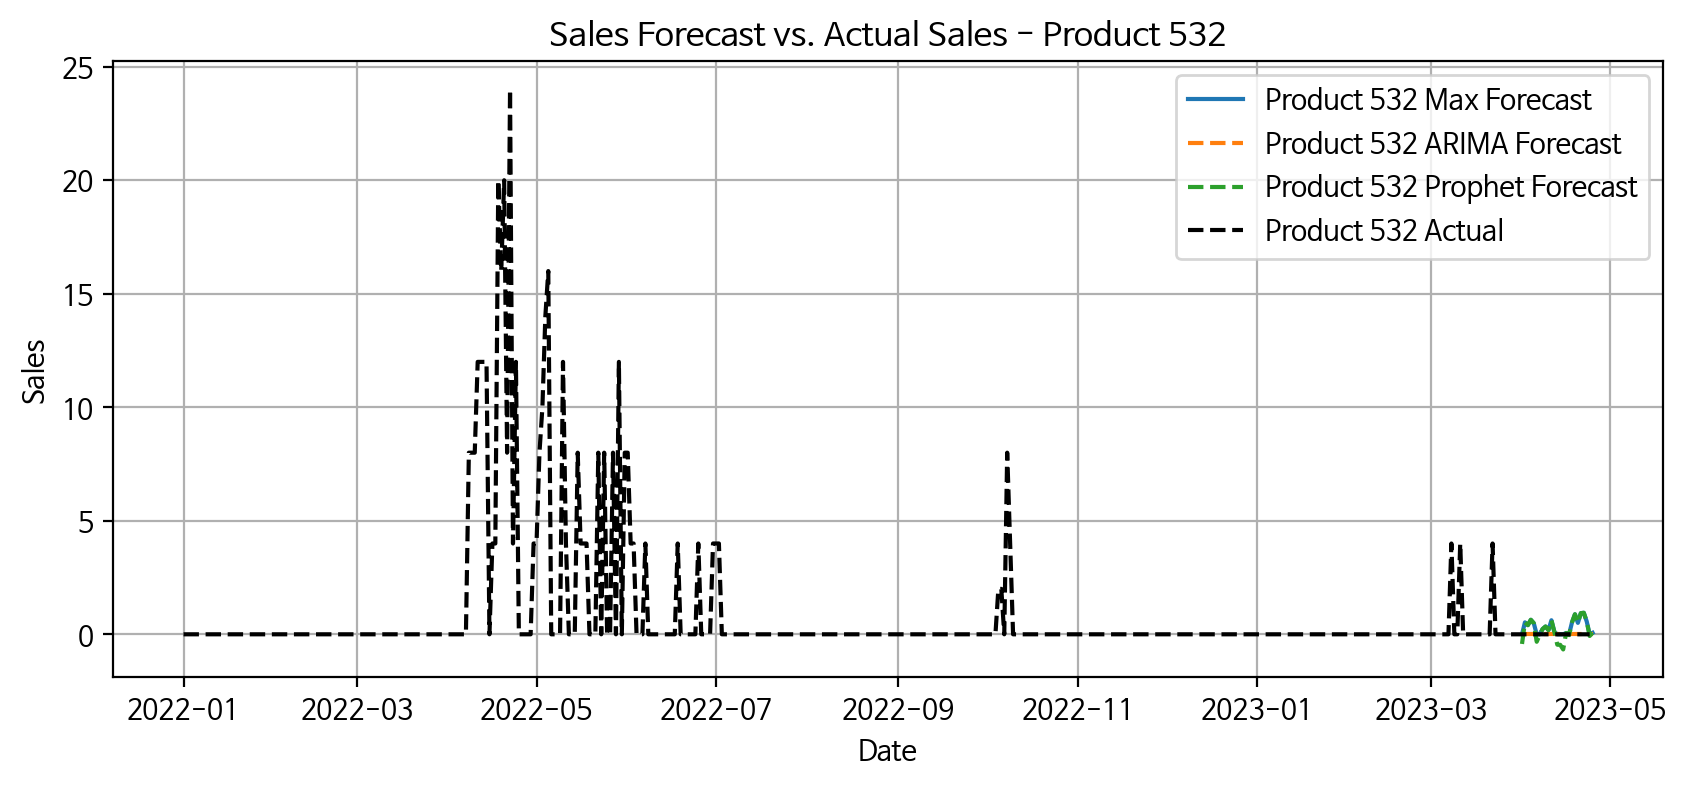

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

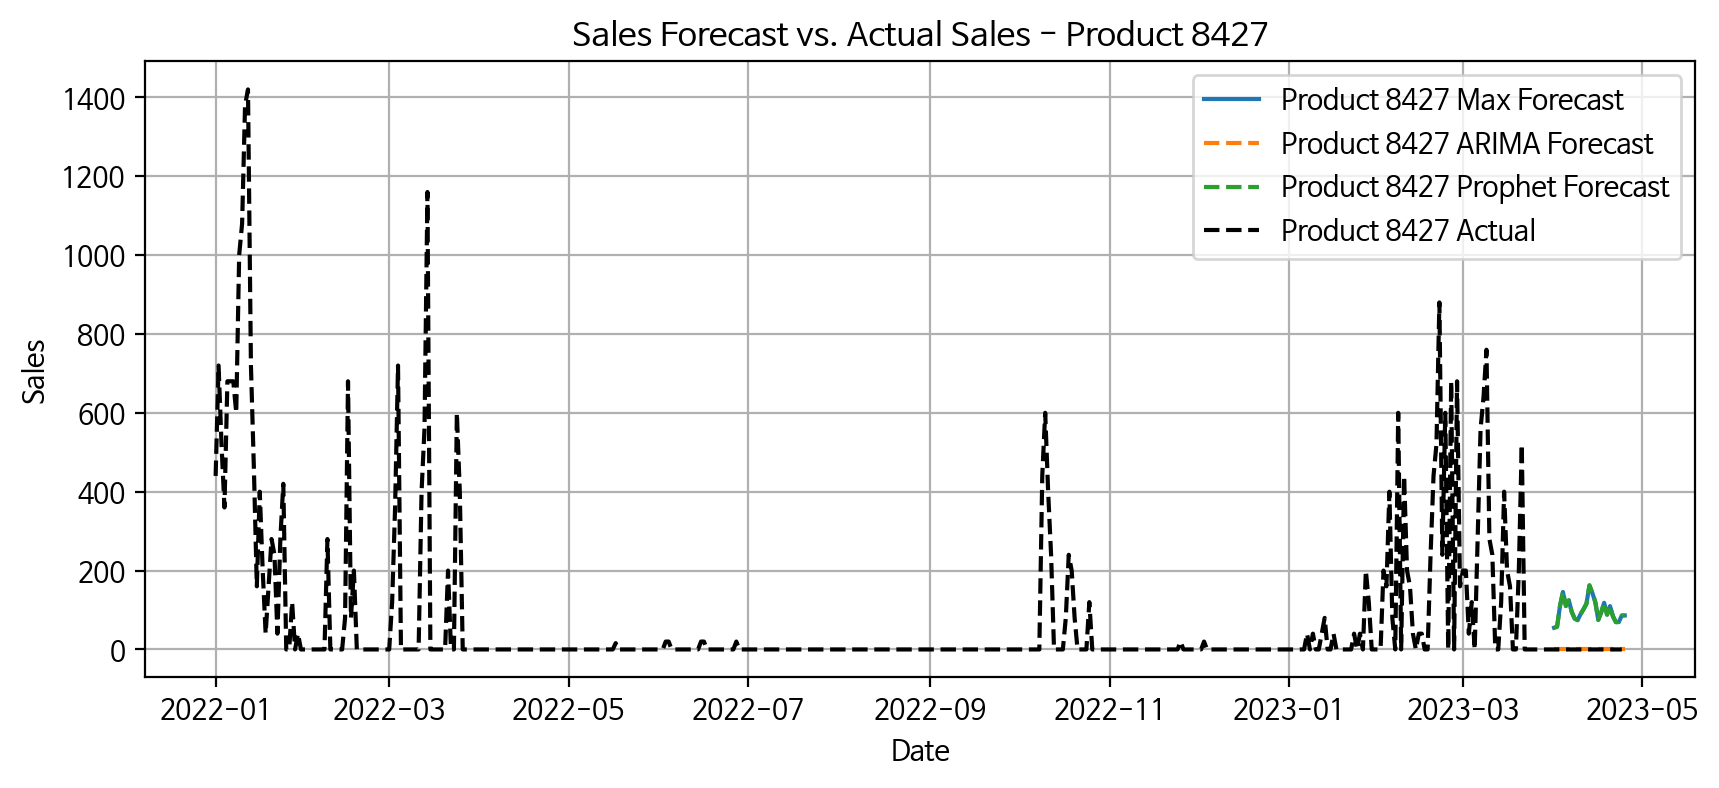

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbcgk903x/74sev946.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbcgk903x/0cbm3y67.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95940', 'data', 'file=/tmp/tmpbcgk903x/74sev946.json', 'init=/tmp/tmpbcgk903x/0cbm3y67.json', 'output', 'file=/tmp/tmpbcgk903x/prophet_modeljmppih6h/prophet_model-20230916122427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


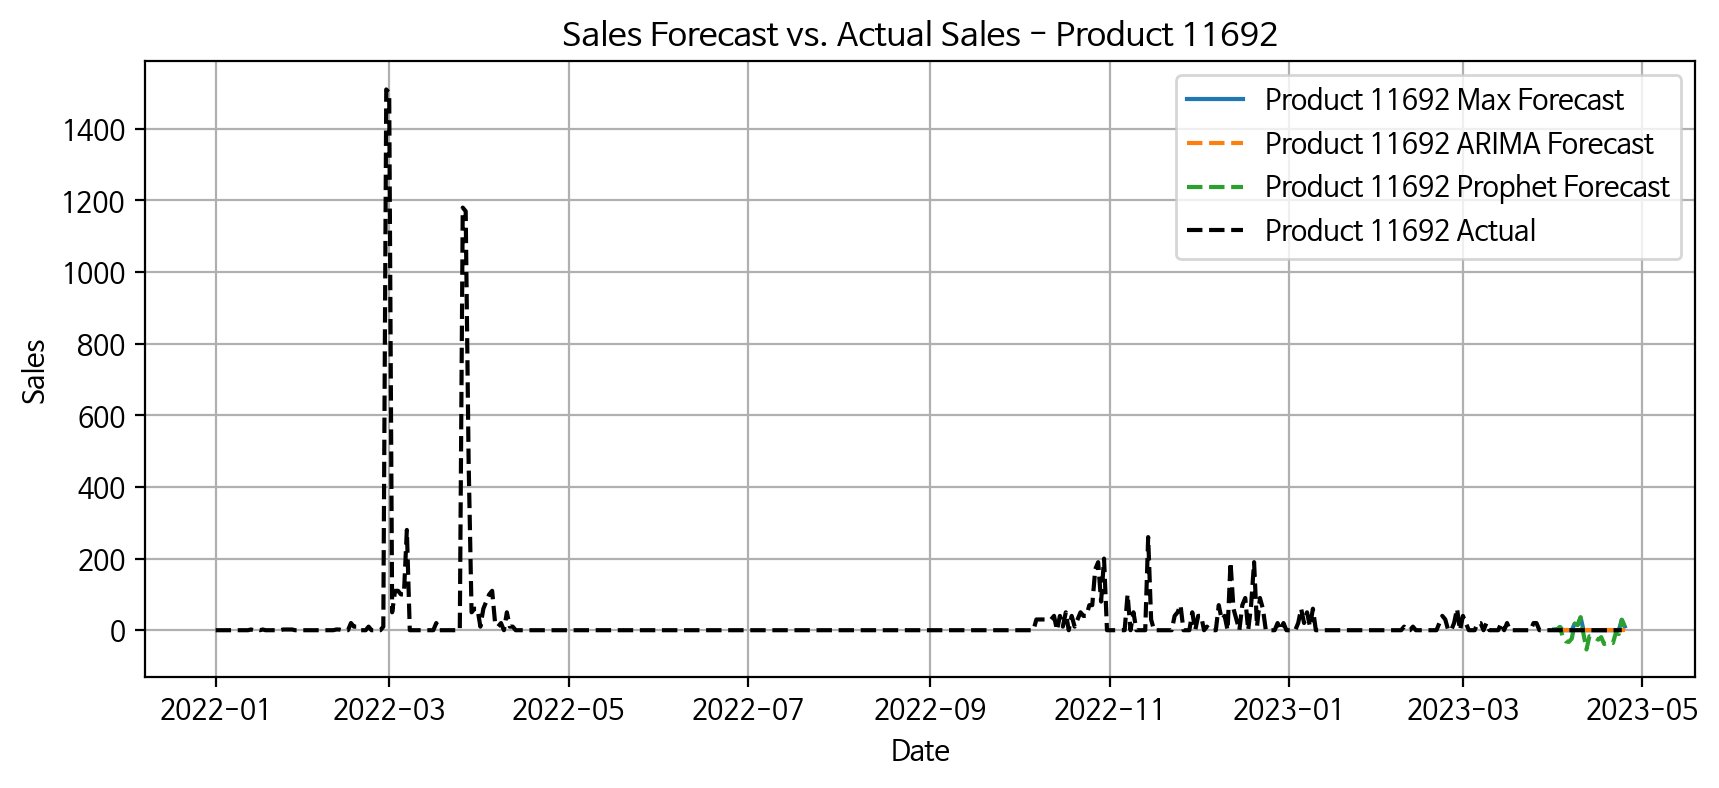

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbcgk903x/czy9afiu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbcgk903x/ncj2a9oo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8445', 'data', 'file=/tmp/tmpbcgk903x/czy9afiu.json', 'init=/tmp/tmpbcgk903x/ncj2a9oo.json', 'output', 'file=/tmp/tmpbcgk903x/prophet_modell66wed3d/prophet_model-20230916122428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


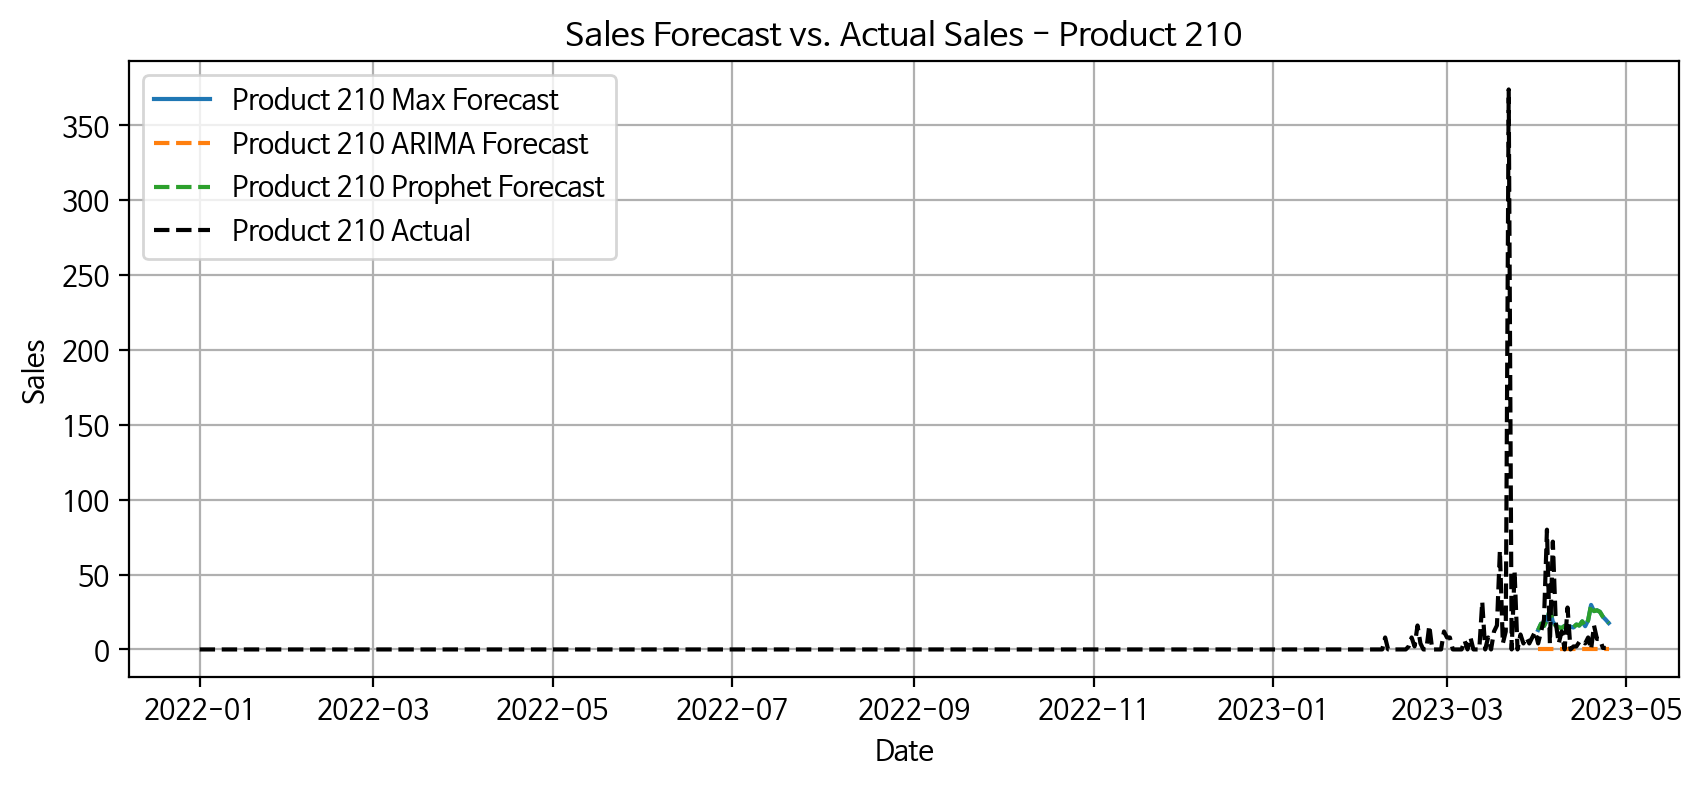

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbcgk903x/obcbq08v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbcgk903x/_avbjcdu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39249', 'data', 'file=/tmp/tmpbcgk903x/obcbq08v.json', 'init=/tmp/tmpbcgk903x/_avbjcdu.json', 'output', 'file=/tmp/tmpbcgk903x/prophet_modelqdn5osdu/prophet_model-20230916122429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


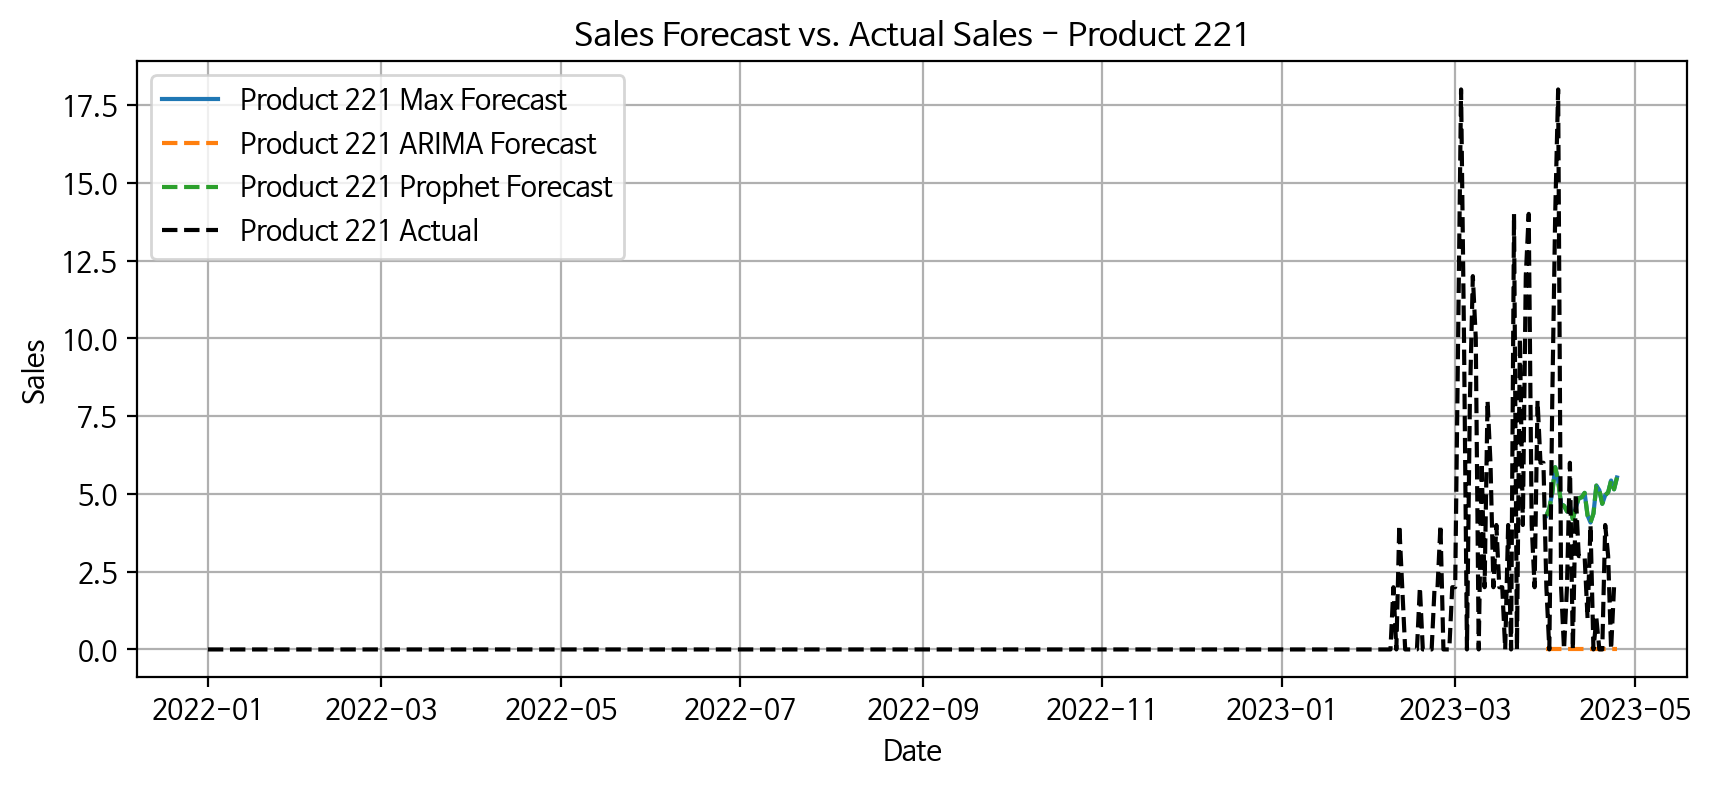

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbcgk903x/ag3bd1vs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbcgk903x/dgusgss0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86715', 'data', 'file=/tmp/tmpbcgk903x/ag3bd1vs.json', 'init=/tmp/tmpbcgk903x/dgusgss0.json', 'output', 'file=/tmp/tmpbcgk903x/prophet_modelrfkmrzvg/prophet_model-20230916122430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:24:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:24:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


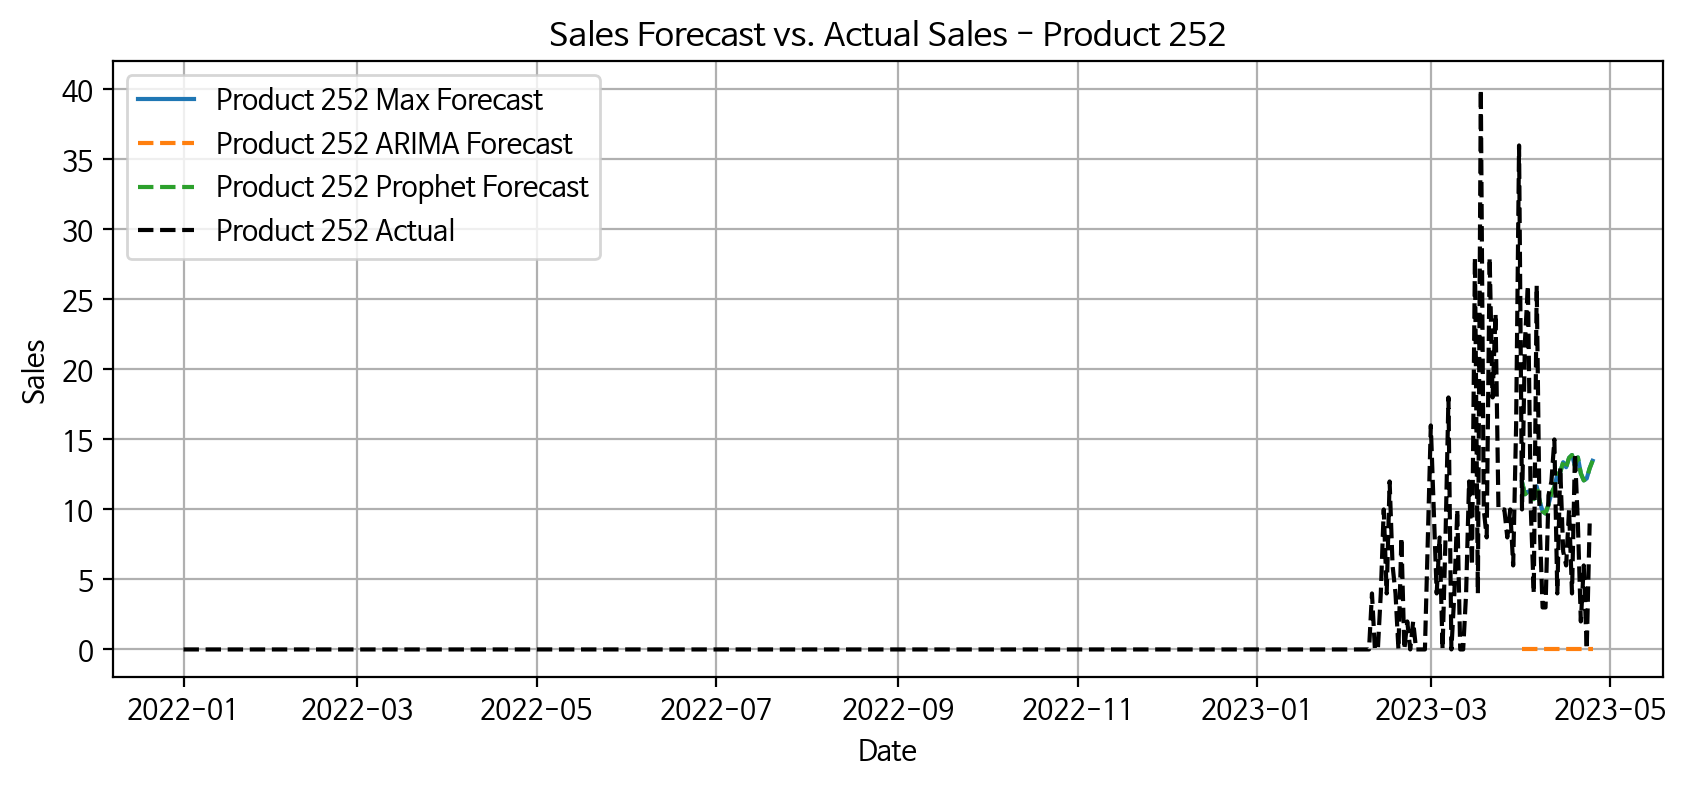

In [ ]:
# 원하는 10개의 제품 ID를 선택
fixed_product_ids = [1, 2, 3, 8, 14, 20, 9, 15, 51, 10, 12, 16, 827, 1533, 1688, 607, 4042, 9081, 1732, 1919, 4880, 401, 532, 550, 1734, 8427, 11692, 210, 221, 252]  # 원하는 제품 ID를 명시적으로 지정하세요

# train 데이터프레임을 준비하세요.
train.set_index('time', inplace=True)

forecast_range = pd.date_range(start='2023-04-01', periods=25)

all_forecasts = {}

# 예측과 실제 값을 저장할 데이터프레임 생성
forecast_df = pd.DataFrame(index=forecast_range)

for product in fixed_product_ids:
    ts = train[train['ID'] == product]['sell']

    # 과거 60일 데이터의 최대값과 최소값을 계산
    start_date = forecast_range[0] - pd.DateOffset(days=60)
    last_60_days = ts.loc[start_date:forecast_range[0] - pd.DateOffset(days=1)]
    max_sell_60 = last_60_days.max()
    min_sell_60 = last_60_days.min()

    # 해당 제품에 대한 max_sell_all 계산
    max_sell_all_product = ts.max()

    # 과거 60일 기간의 max-min 값이 전체 max 값의 1% 미만인 경우 ARIMA 모델 사용
    if (max_sell_60 - min_sell_60) / max_sell_all_product < 0.02:
        # ARIMA 모델 피팅
        model = ARIMA(ts, order=(5, 1, 0))
        model_fit = model.fit()
        forecast_arima = model_fit.forecast(steps=25)

        forecast = forecast_arima
        model_name = 'ARIMA'
    else:
        # Prophet 모델 피팅
        x_df = pd.DataFrame()
        x_df['ds'] = ts.index
        x_df['y'] = ts.values

        prophet = Prophet(seasonality_mode='additive',
                          yearly_seasonality=False,
                          weekly_seasonality='auto', daily_seasonality=False,
                          changepoint_prior_scale=0.5)
        prophet.add_country_holidays(country_name='KR')
        prophet.add_seasonality(name='2_week', period=14, fourier_order=5)
        prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)

        prophet.fit(x_df)

        future_data = prophet.make_future_dataframe(periods=25, freq='D')

        forecast_prophet = prophet.predict(future_data)

        # Prophet 모델의 예측 값을 ARIMA 모델의 예측 길이에 맞추기
        forecast_prophet = forecast_prophet[forecast_prophet['ds'].isin(forecast_range)]

        forecast = forecast_prophet['yhat'].values
        model_name = 'Prophet'

        # ARIMA 모델로 예측한 데이터 길이 조정
        forecast_arima = forecast_arima[:len(forecast_range)]

        max_forecast = np.maximum(forecast_arima, forecast_prophet['yhat'].values)
        max_forecast[max_forecast < 0] = 0

        # 그래프 그리기
        plt.figure(figsize=(10, 4))
        plt.plot(forecast_range, max_forecast, label=f'Product {product} Max Forecast')
        plt.plot(forecast_range, forecast_arima, label=f'Product {product} ARIMA Forecast', linestyle='--')
        plt.plot(forecast_range, forecast_prophet['yhat'].values, label=f'Product {product} Prophet Forecast', linestyle='--')
        plt.plot(ts.index, ts.values, label=f'Product {product} Actual', linestyle='--', color='black')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.title(f'Sales Forecast vs. Actual Sales - Product {product}')
        plt.legend()
        plt.grid(True)
        plt.show()


In [ ]:
# 대분류
arima_params ={
    'B002-C001-0002' : (2, 1, 1),
    'B002-C001-0003' : (3, 1, 2),
    'B002-C001-0001' : (2, 1, 2),
    'B002-C001-0005' : (2, 1, 2),
    'B002-C001-0004' : (3, 1, 3),
}

In [ ]:
# 원하는 10개의 제품 ID를 선택
fixed_product_ids = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]  # 원하는 제품 ID를 명시적으로 지정하세요

# train 데이터프레임을 준비하세요.
train.set_index('time', inplace=True)

forecast_range = pd.date_range(start='2023-04-01', periods=55)

all_forecasts = {}

# 예측과 실제 값을 저장할 데이터프레임 생성
forecast_df = pd.DataFrame(index=forecast_range)

for product in fixed_product_ids:  # 랜덤 대신 고정된 제품 ID를 순회합니다.
    ts = train[train['ID'] == product]['sell']

    model = ARIMA(ts, order=(4, 1, 0))
    model_fit = model.fit()
    forecast_arima = model_fit.forecast(steps=55)

    # Prophet 모델 피팅
    x_df = pd.DataFrame()
    x_df['ds'] = ts.index
    x_df['y'] = ts.values

    prophet = Prophet(seasonality_mode='additive',
                      yearly_seasonality=False,
                      weekly_seasonality='auto', daily_seasonality=False,
                      changepoint_prior_scale=0.5)
    prophet.add_country_holidays(country_name='KR')

    prophet.fit(x_df)

    future_data = prophet.make_future_dataframe(periods=55, freq='D')

    forecast_prophet = prophet.predict(future_data)

    # Prophet 모델의 예측 값을 ARIMA 모델의 예측 길이에 맞추기
    forecast_prophet = forecast_prophet[forecast_prophet['ds'].isin(forecast_range)]

    # ARIMA와 Prophet 모델의 예측 값을 최종 예측으로 조합
    max_forecast = np.maximum(forecast_arima, forecast_prophet['yhat'].values)
    max_forecast[max_forecast < 0] = 0

    all_forecasts[product] = max_forecast

    # # 각 제품에 대한 예측 그래프 그리기
    # plt.figure(figsize=(10, 4))
    # plt.plot(forecast_range, max_forecast, label=f'Product {product} Forecast')
    # plt.plot(ts.index, ts.values, label=f'Product {product} Actual', linestyle='--', color='black')
    # plt.xlabel('Date')
    # plt.ylabel('Sales')
    # plt.title(f'Sales Forecast vs. Actual Sales - Product {product}')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(forecast_range, max_forecast, label=f'Product {product} Max Forecast')
    plt.plot(forecast_range, forecast_arima, label=f'Product {product} ARIMA Forecast', linestyle='--')
    plt.plot(forecast_range, forecast_prophet['yhat'].values, label=f'Product {product} Prophet Forecast', linestyle='--')
    plt.plot(ts.index, ts.values, label=f'Product {product} Actual', linestyle='--', color='black')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Sales Forecast vs. Actual Sales - Product {product}')
    plt.legend()
    plt.grid(True)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 각 제품에 대한 평가 지표를 저장할 딕셔너리
evaluation_metrics = {}

for product in fixed_product_ids:
    ts = train[train['ID'] == product]['sell']
    actual_values = ts[-52:]  # 실제 값은 예측 기간의 마지막 52개 데이터입니다.

    # 모델이 예측한 값
    predicted_values = all_forecasts[product]

    # 평가 지표 계산
    mse = mean_squared_error(actual_values, predicted_values)
    mae = mean_absolute_error(actual_values, predicted_values)

    # 결과 저장
    evaluation_metrics[f'Product {product}'] = {'MSE': mse, 'MAE': mae}

# 평가 지표 출력
for product, metrics in evaluation_metrics.items():
    print(f'{product} - MSE: {metrics["MSE"]}, MAE: {metrics["MAE"]}')

Product 1 - MSE: 0.8048712828068505, MAE: 0.7410016394167894
Product 2 - MSE: 0.8302315593125967, MAE: 0.5433993540961699
Product 3 - MSE: 10.609259995388815, MAE: 1.3807283579025684
Product 4 - MSE: 20.972029015961706, MAE: 4.217535122217752
Product 5 - MSE: 0.9589333530589349, MAE: 0.5992060945218888
Product 6 - MSE: 0.4502732778452281, MAE: 0.38897948430797985
Product 7 - MSE: 19.44131482496687, MAE: 2.8307857900361357
Product 8 - MSE: 1.9250096069576434, MAE: 1.2880859902125155
Product 9 - MSE: 122.50977509695744, MAE: 9.352283425522408
Product 10 - MSE: 0.06118002548574792, MAE: 0.1318096786664863


In [2]:
# !pip install pmdarima

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=1113.327, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1122.094, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1112.451, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1108.744, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1120.094, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=1113.521, Time=0.08 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=1110.403, Time=0.56 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=1110.485, Time=0.62 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=1109.202, Time=0.18 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=1112.401, Time=1.45 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=1122.243, Time=0.19 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=1075.220, Time=1.86 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=1093.451, Time=0.22 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=1091.245, Time=1.42 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
DEBUG:cmdstanpy:input tempfile: /tmp/tmppodq791u/fv_vcpbd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppodq791u/yrpq4qvs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35475', 'data', 'file=/tmp/tmppodq791u/fv_vcpbd.json', 'init=/tmp/tm

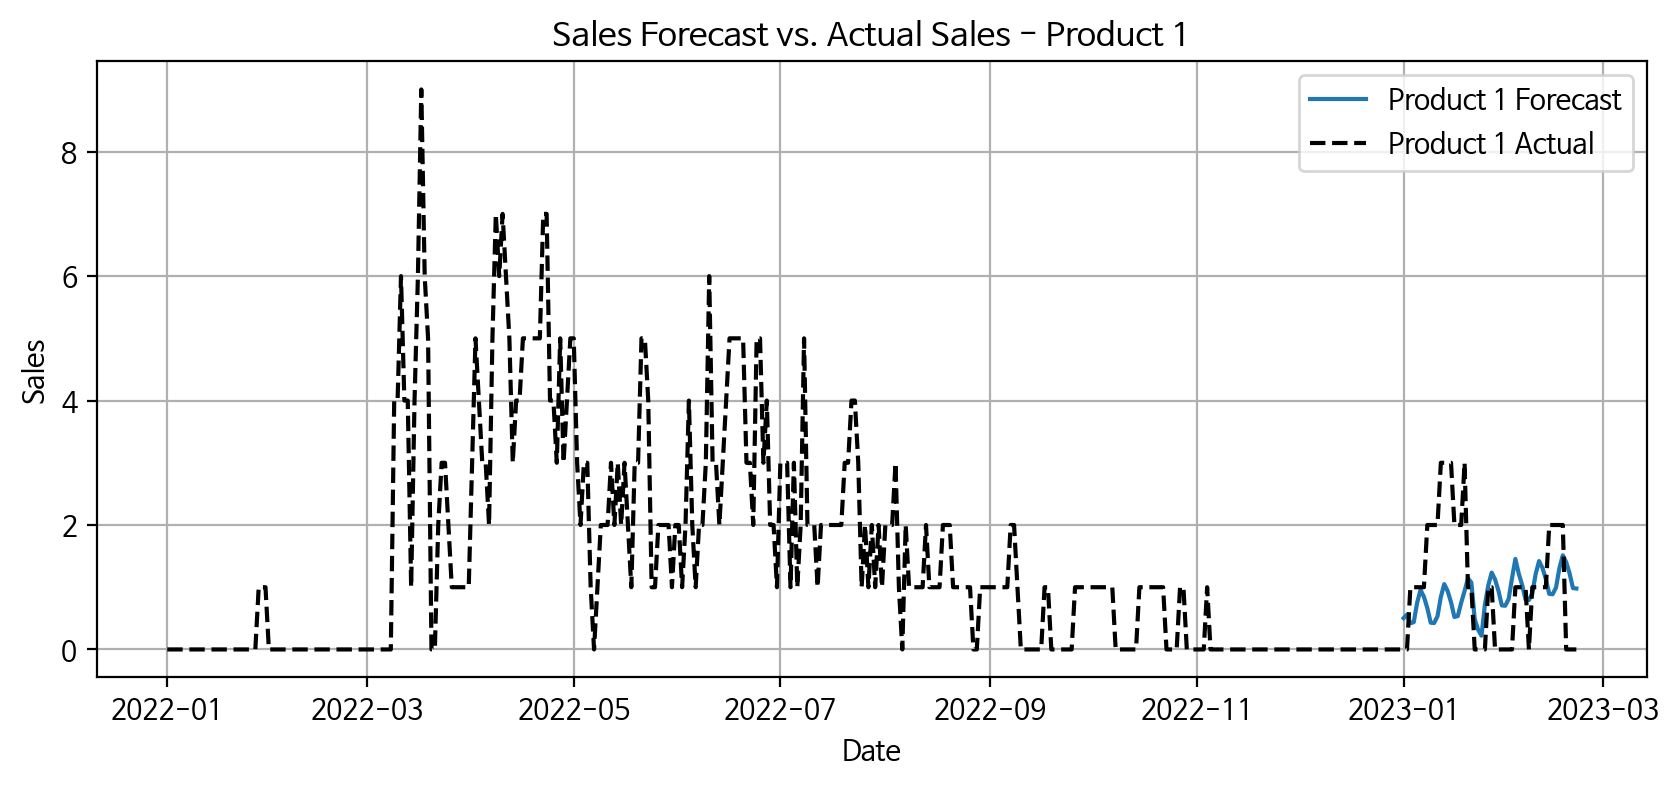

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=1895.405, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1892.275, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1893.432, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1893.489, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1890.275, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=1893.140, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=1893.165, Time=0.16 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=1895.111, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1892.616, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=1892.642, Time=0.06 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
DEBUG:cmdstanpy:input tempfile: /tmp/tmppodq791u/811nv3kq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppodq791u/u13v2bug.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58319', 'data', 'file=/tmp/tmppodq791u/811nv3kq.json', 'init=/tmp/tm

 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=1894.614, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 1.598 seconds


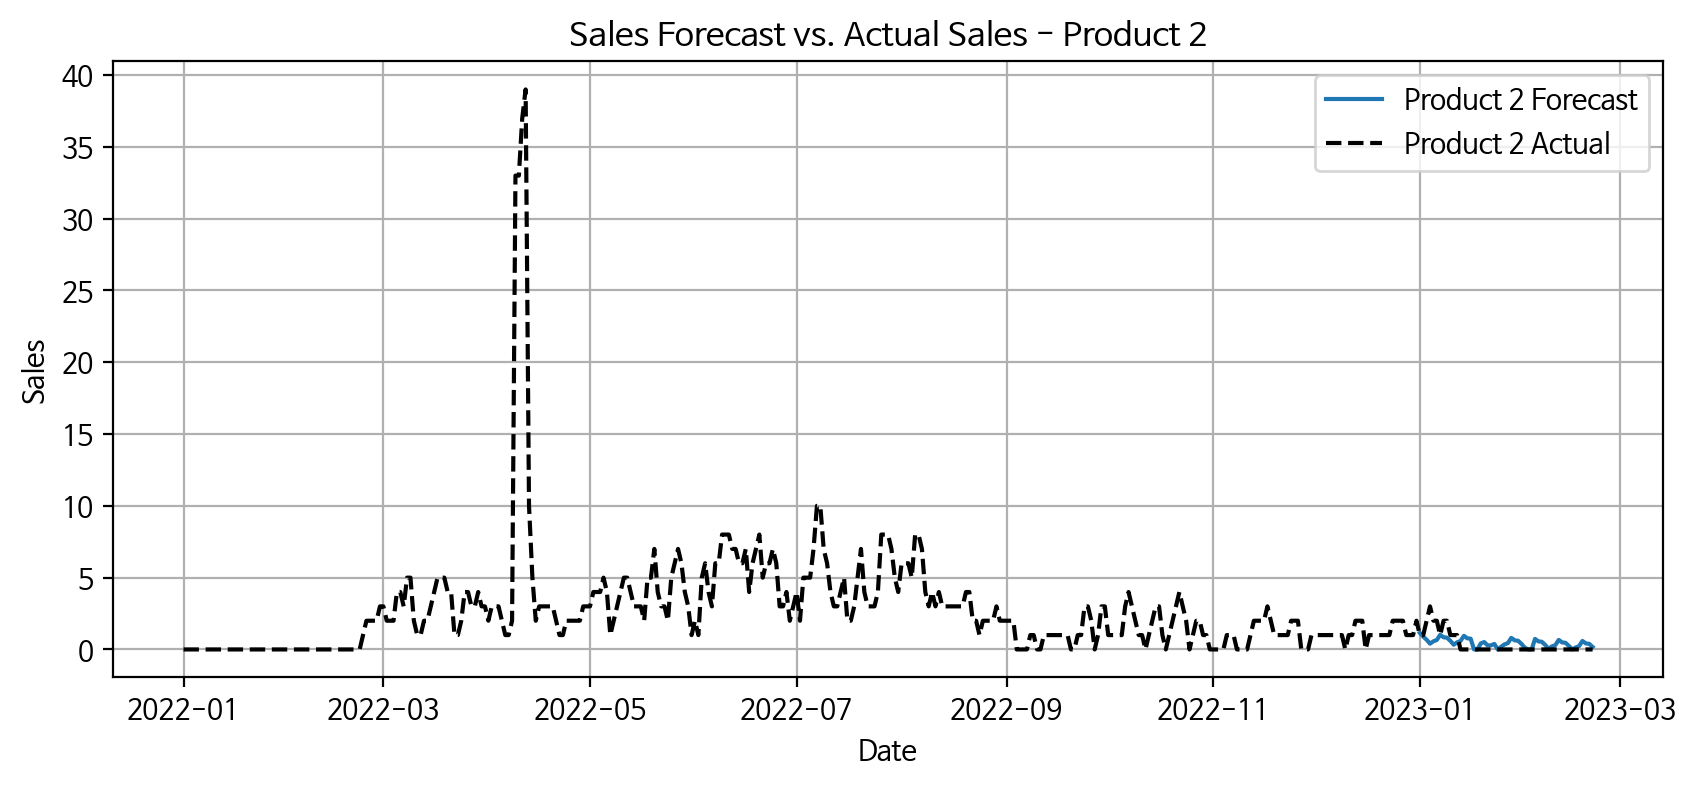

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=2576.995, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2573.104, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2575.301, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2575.233, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2571.104, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=2574.957, Time=0.10 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=2574.966, Time=0.18 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=2576.720, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=2573.422, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=2573.345, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=2558.295, Time=0.19 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=2559.776, Time=0.91 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=2559.815, Time=0.80 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=2561.197, Time=1.35 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
DEBUG:cmdstanpy:input tempfile: /tmp/tmppodq791u/5p6ccsvy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppodq791u/85svyafw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89821', 'data', 'file=/tmp/tmppodq791u/5p6ccsvy.json', 'init=/tmp/tm

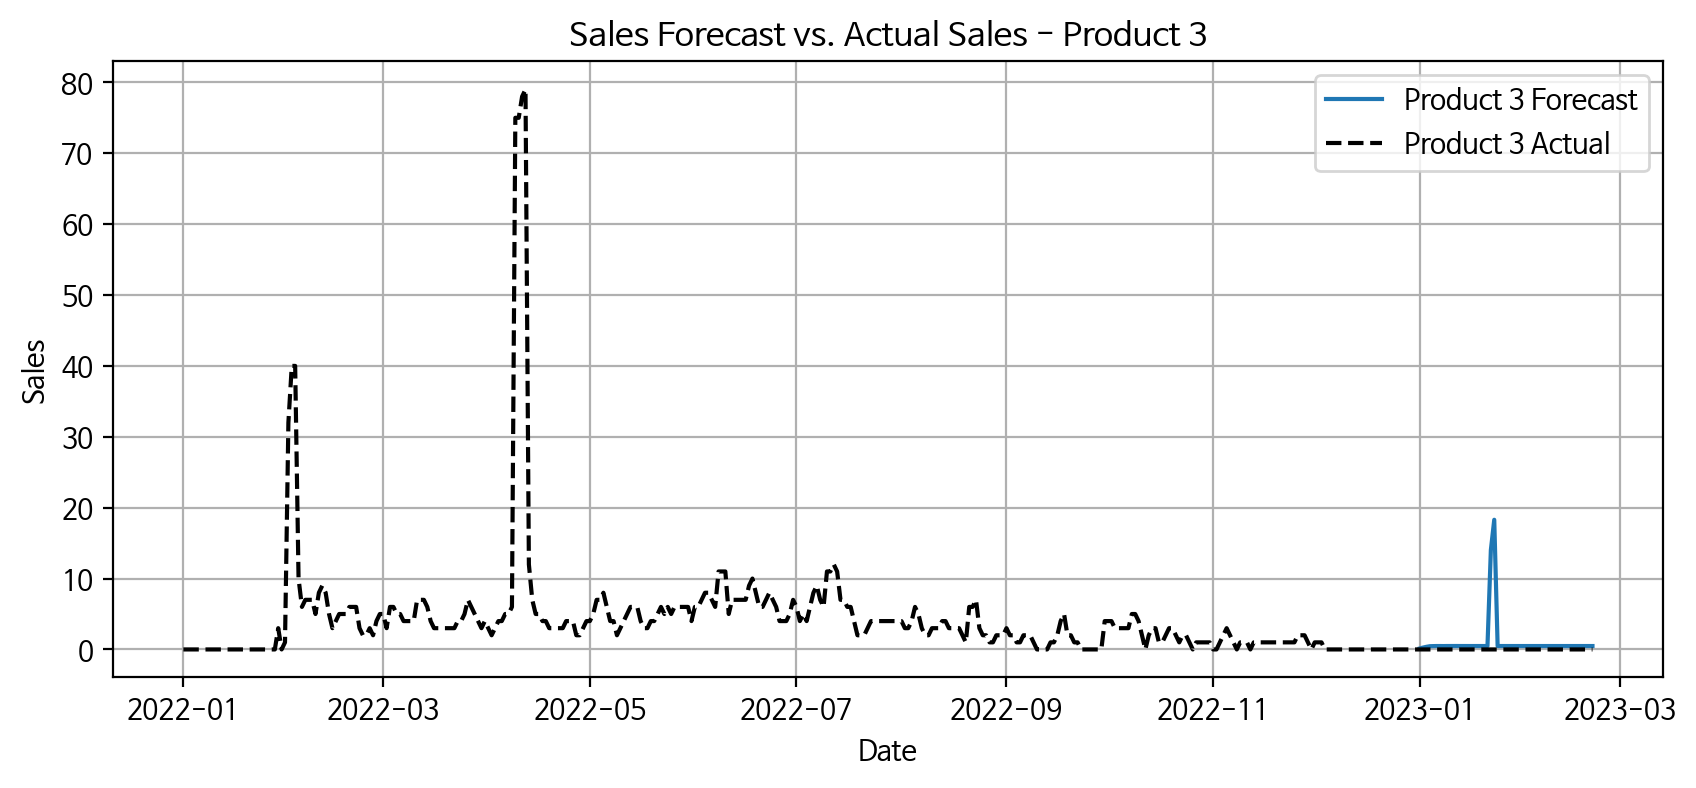

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=2601.062, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2604.952, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2600.449, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2598.580, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2602.952, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=2597.130, Time=0.09 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=2598.445, Time=0.17 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=2596.498, Time=0.52 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=2596.045, Time=1.19 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=2594.109, Time=0.46 sec
 ARIMA(0,1,1)(3,0,0)[7] intercept   : AIC=2596.099, Time=1.04 sec
 ARIMA(0,1,1)(3,0,1)[7] intercept   : AIC=2597.661, Time=2.28 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=2604.236, Time=0.39 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=2536.128, Time=1.26 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
DEBUG:cmdstanpy:input tempfile: /tmp/tmppodq791u/sc74dgk8.json


 ARIMA(2,1,2)(2,0,0)[7]             : AIC=inf, Time=1.64 sec

Best model:  ARIMA(1,1,1)(2,0,0)[7]          
Total fit time: 43.355 seconds


DEBUG:cmdstanpy:input tempfile: /tmp/tmppodq791u/tmak_vlf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82334', 'data', 'file=/tmp/tmppodq791u/sc74dgk8.json', 'init=/tmp/tmppodq791u/tmak_vlf.json', 'output', 'file=/tmp/tmppodq791u/prophet_modelz3mgk2ug/prophet_model-20230912093311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:33:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:33:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


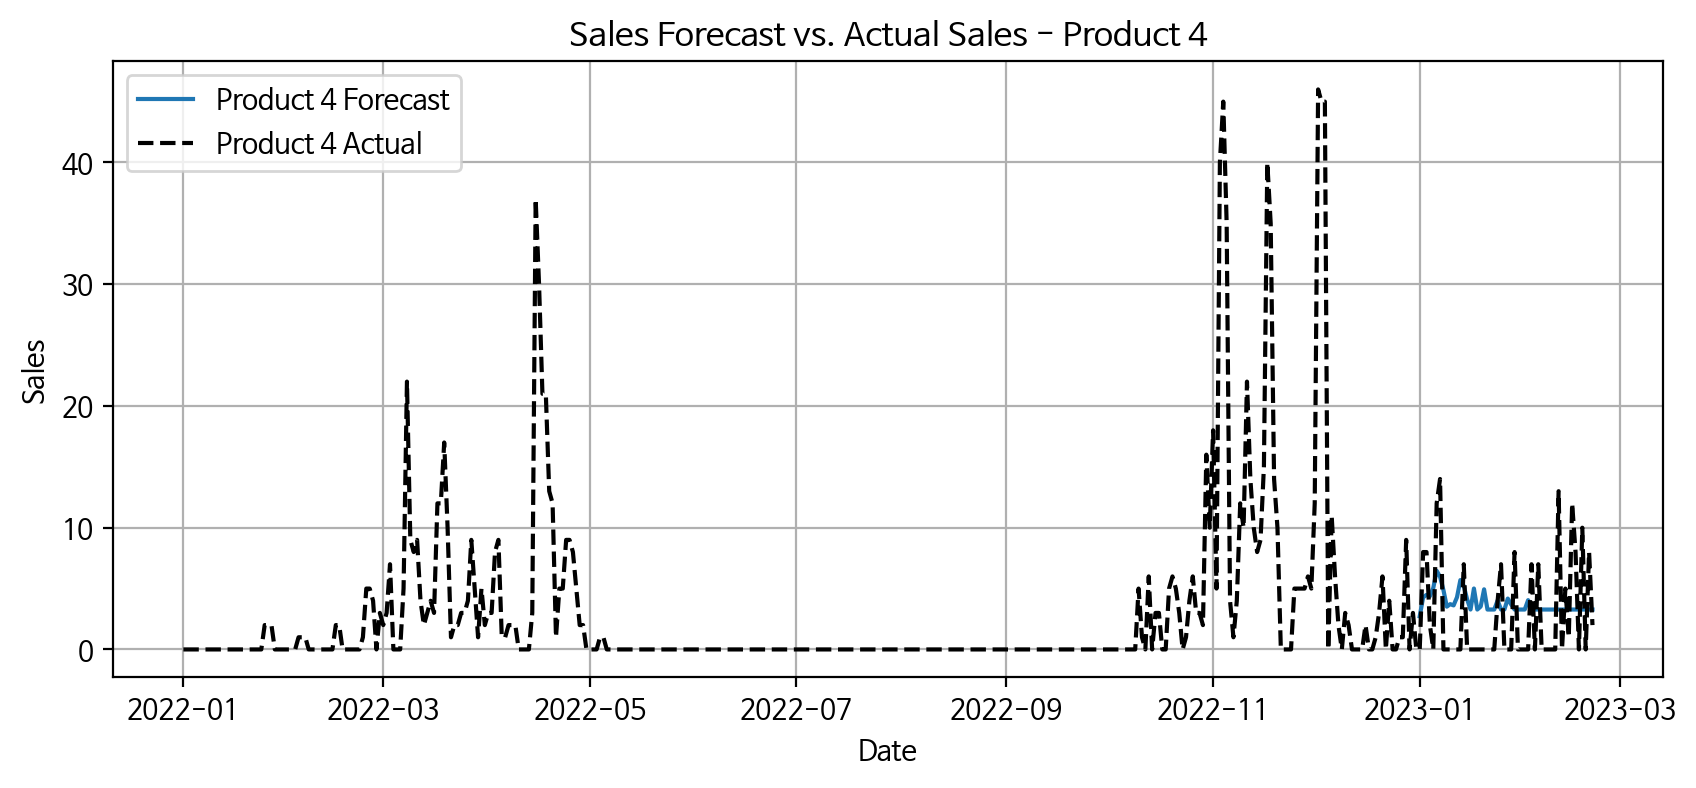

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=1889.310, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1886.025, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1887.367, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1887.340, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1884.025, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=1887.130, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=1887.114, Time=0.15 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=1888.263, Time=0.50 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1886.094, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=1886.074, Time=0.05 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
DEBUG:cmdstanpy:input tempfile: /tmp/tmppodq791u/m6a3eaou.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppodq791u/0l4v9eef.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49847', 'data', 'file=/tmp/tmppodq791u/m6a3eaou.json', 'init=/tmp/tm

 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=1885.181, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 1.746 seconds


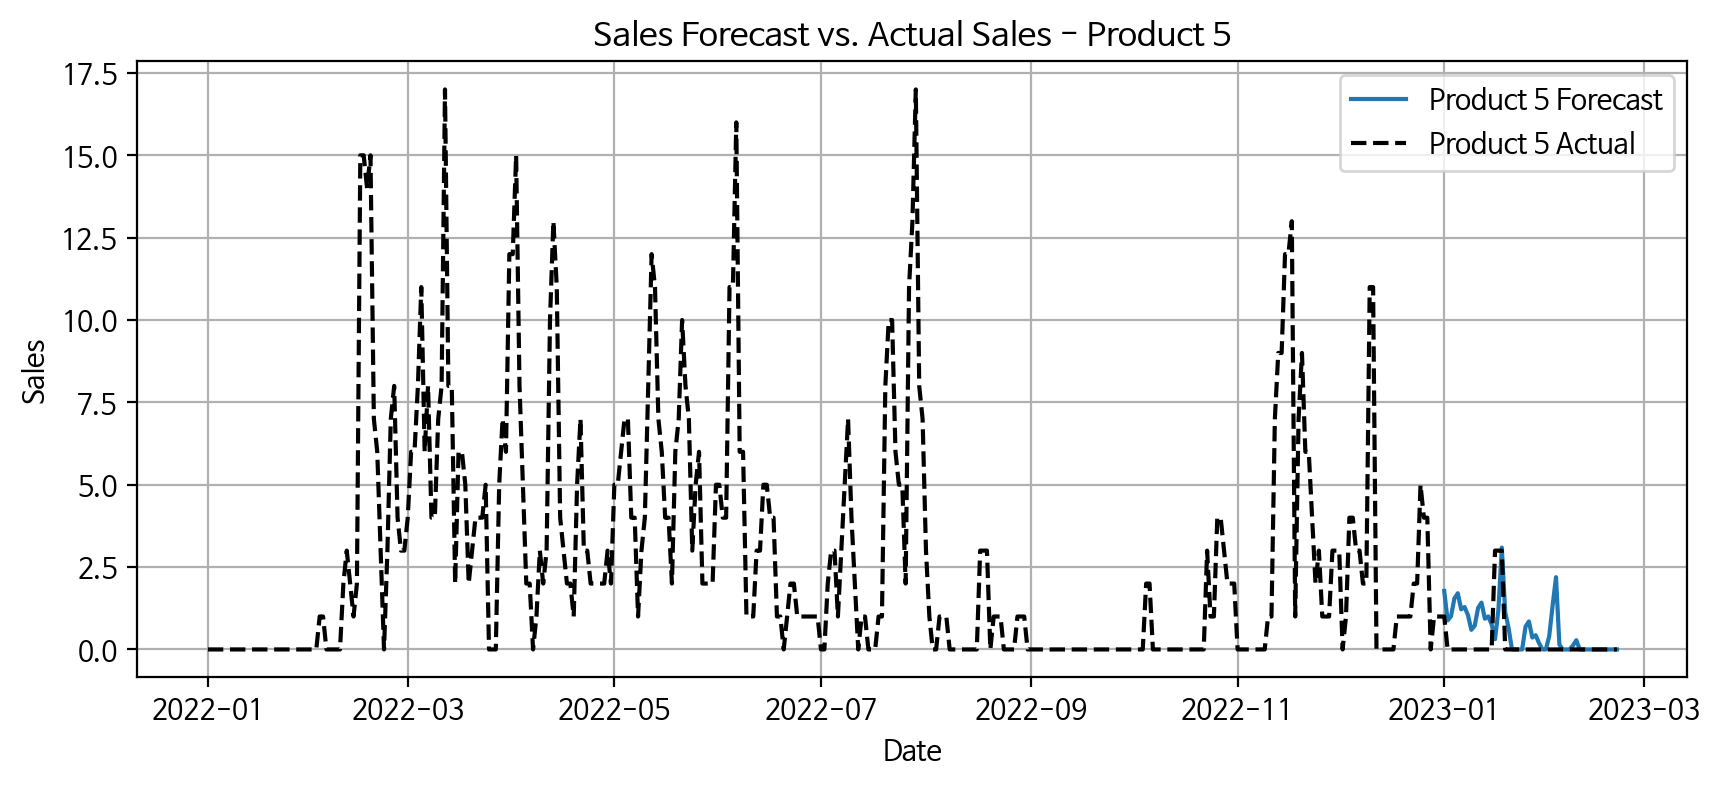

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=1900.993, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1898.792, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1900.319, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1900.211, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1896.792, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=1900.674, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=1900.680, Time=0.16 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=1901.615, Time=0.71 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1898.416, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=1898.302, Time=0.07 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
DEBUG:cmdstanpy:input tempfile: /tmp/tmppodq791u/y7hhuw_w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppodq791u/wgspkciy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54085', 'data', 'file=/tmp/tmppodq791u/y7hhuw_w.json', 'init=/tmp/tm

 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=1900.299, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 2.455 seconds


09:33:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


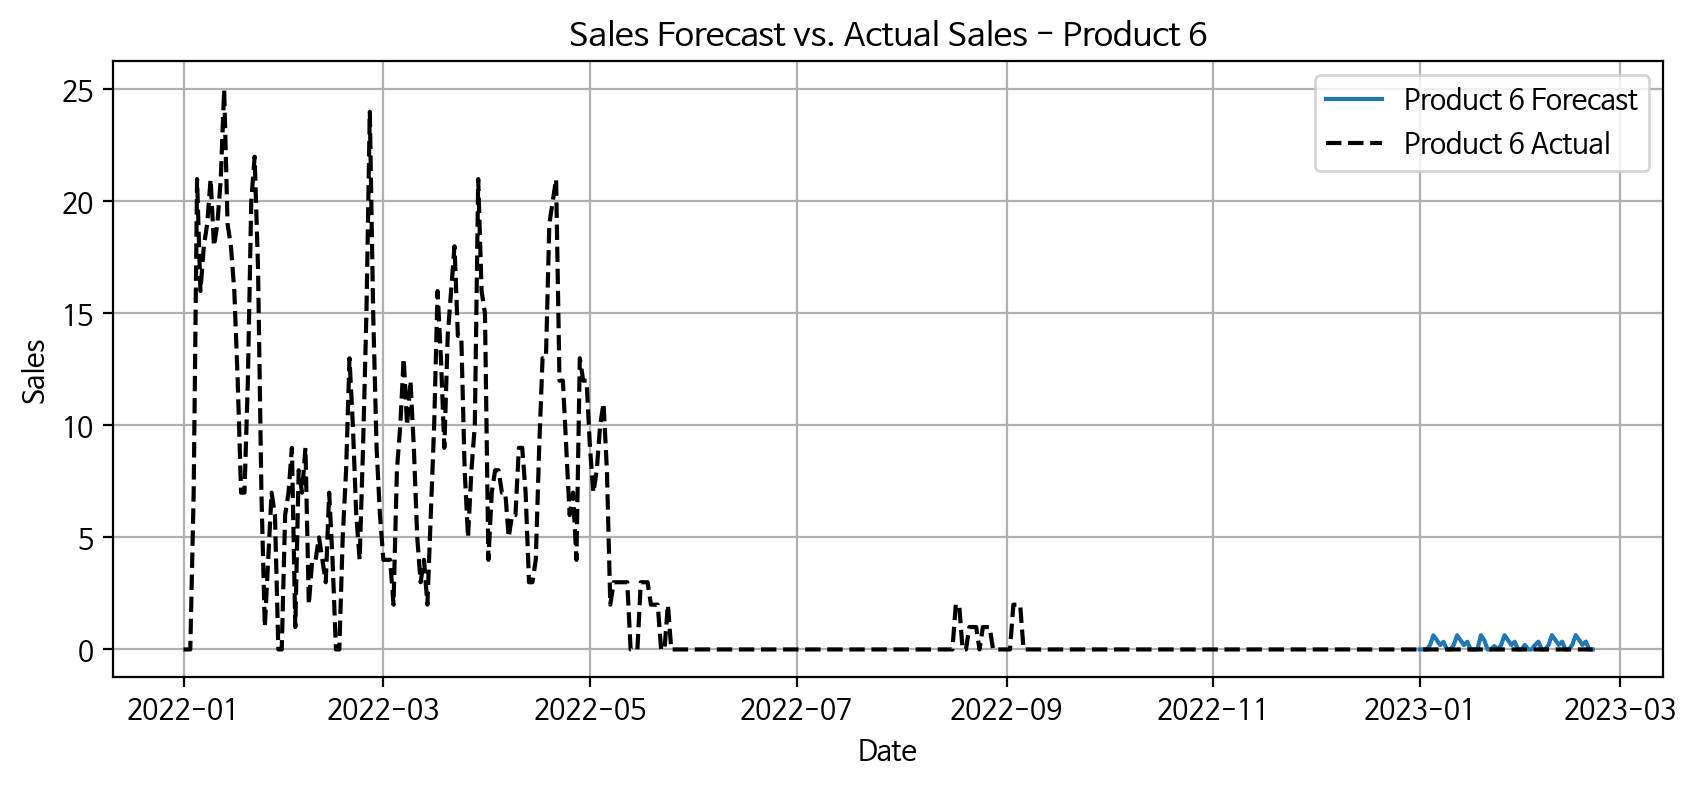

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=3329.995, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3382.156, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3328.569, Time=0.33 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3325.847, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3380.156, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=3325.173, Time=0.11 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=3325.720, Time=0.25 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=3326.838, Time=0.80 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=3325.120, Time=0.19 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=3325.031, Time=0.59 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=3326.918, Time=1.06 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=3326.913, Time=1.07 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=3325.105, Time=0.74 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=3328.909, Time=1.48 sec
 ARIMA(2,1,1)(1,0,0)[7] intercept

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
DEBUG:cmdstanpy:input tempfile: /tmp/tmppodq791u/hj3pkha4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppodq791u/okeuh8s8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19872', 'data', 'file=/tmp/tmppodq791u/hj3pkha4.json', 'init=/tmp/tm

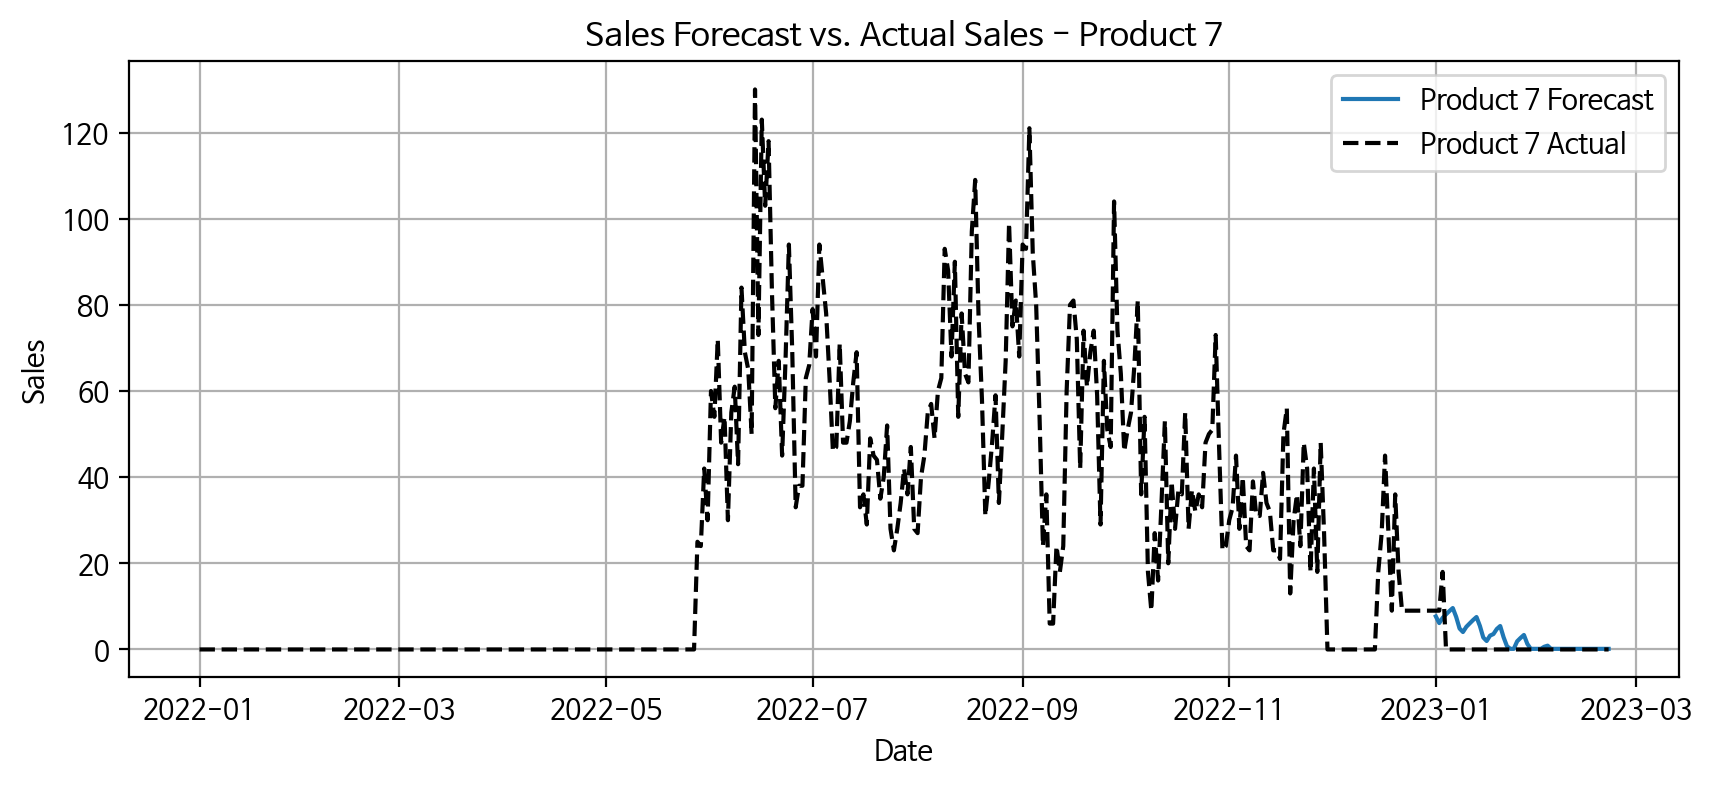

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=1433.315, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1439.608, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1442.006, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1442.136, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1437.608, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=1433.573, Time=0.10 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=1435.279, Time=0.51 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=1435.309, Time=0.49 sec
 ARIMA(2,1,0)(0,0,1)[7] intercept   : AIC=1433.492, Time=0.26 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=1435.419, Time=1.24 sec
 ARIMA(3,1,0)(1,0,0)[7] intercept   : AIC=1306.724, Time=0.58 sec
 ARIMA(3,1,0)(0,0,0)[7] intercept   : AIC=1306.613, Time=0.17 sec
 ARIMA(3,1,0)(0,0,1)[7] intercept   : AIC=1307.008, Time=0.40 sec
 ARIMA(3,1,0)(1,0,1)[7] intercept   : AIC=1308.455, Time=0.85 sec
 ARIMA(4,1,0)(0,0,0)[7] intercept

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
DEBUG:cmdstanpy:input tempfile: /tmp/tmppodq791u/khk3xq6j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppodq791u/8qbjq9ca.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69136', 'data', 'file=/tmp/tmppodq791u/khk3xq6j.json', 'init=/tmp/tm

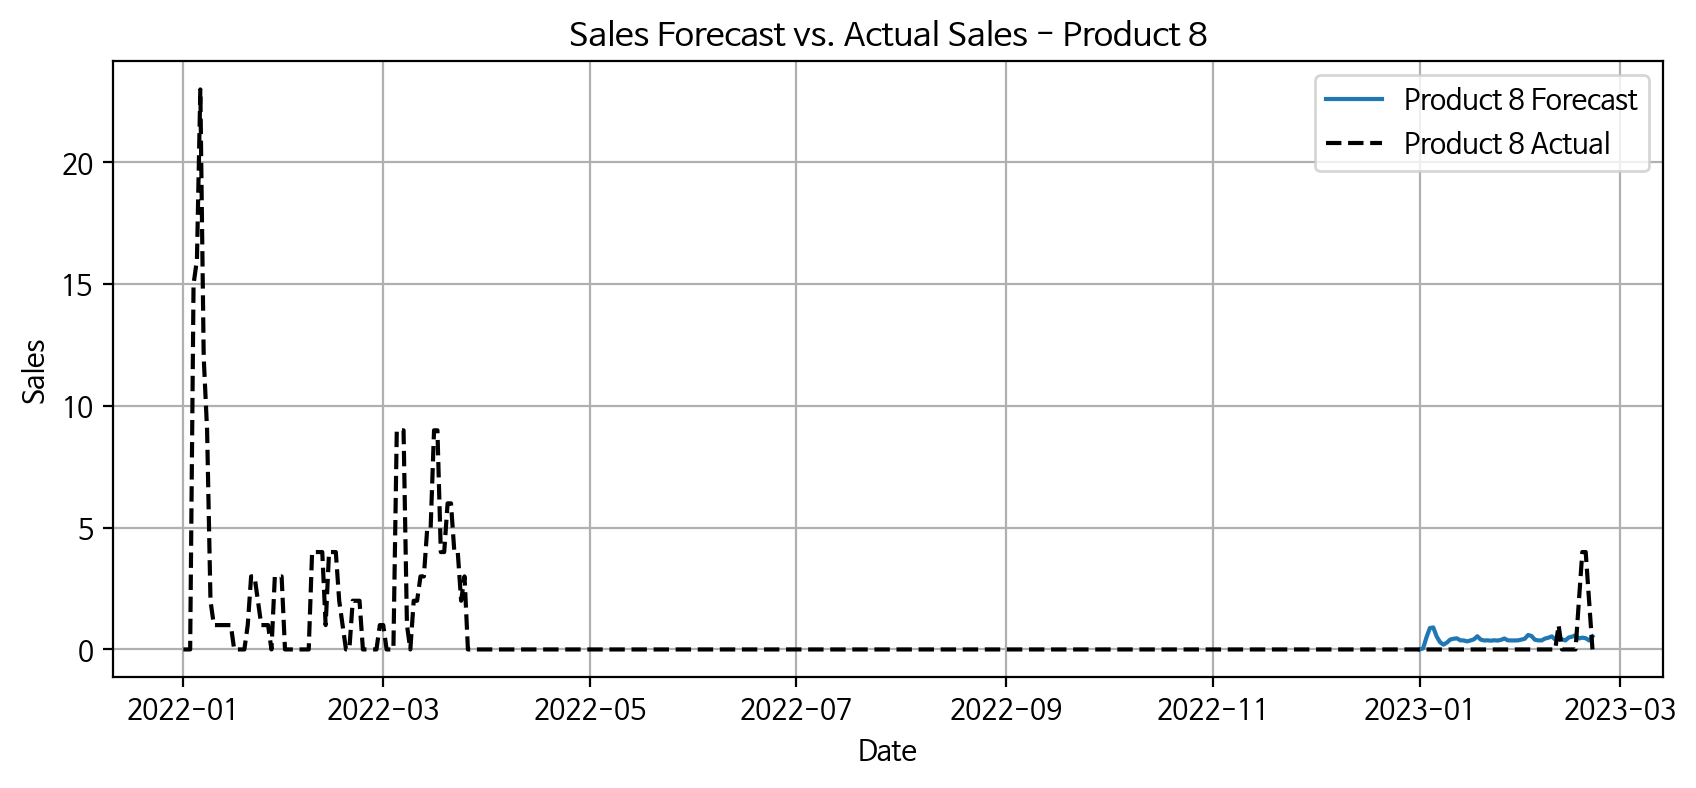

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=2752.279, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2943.474, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2836.152, Time=0.31 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2733.734, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2941.474, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=2733.463, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=2733.970, Time=0.28 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=2732.689, Time=1.25 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=2733.914, Time=1.55 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=2734.055, Time=1.35 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=2733.563, Time=0.60 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=2734.275, Time=0.61 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=2736.143, Time=2.35 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=2942.923, Time=0.46 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
DEBUG:cmdstanpy:input tempfile: /tmp/tmppodq791u/7wwbw0a8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppodq791u/mo3jxg6c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29767', 'data', 'file=/tmp/tmppodq791u/7wwbw0a8.json', 'init=/tmp/tm

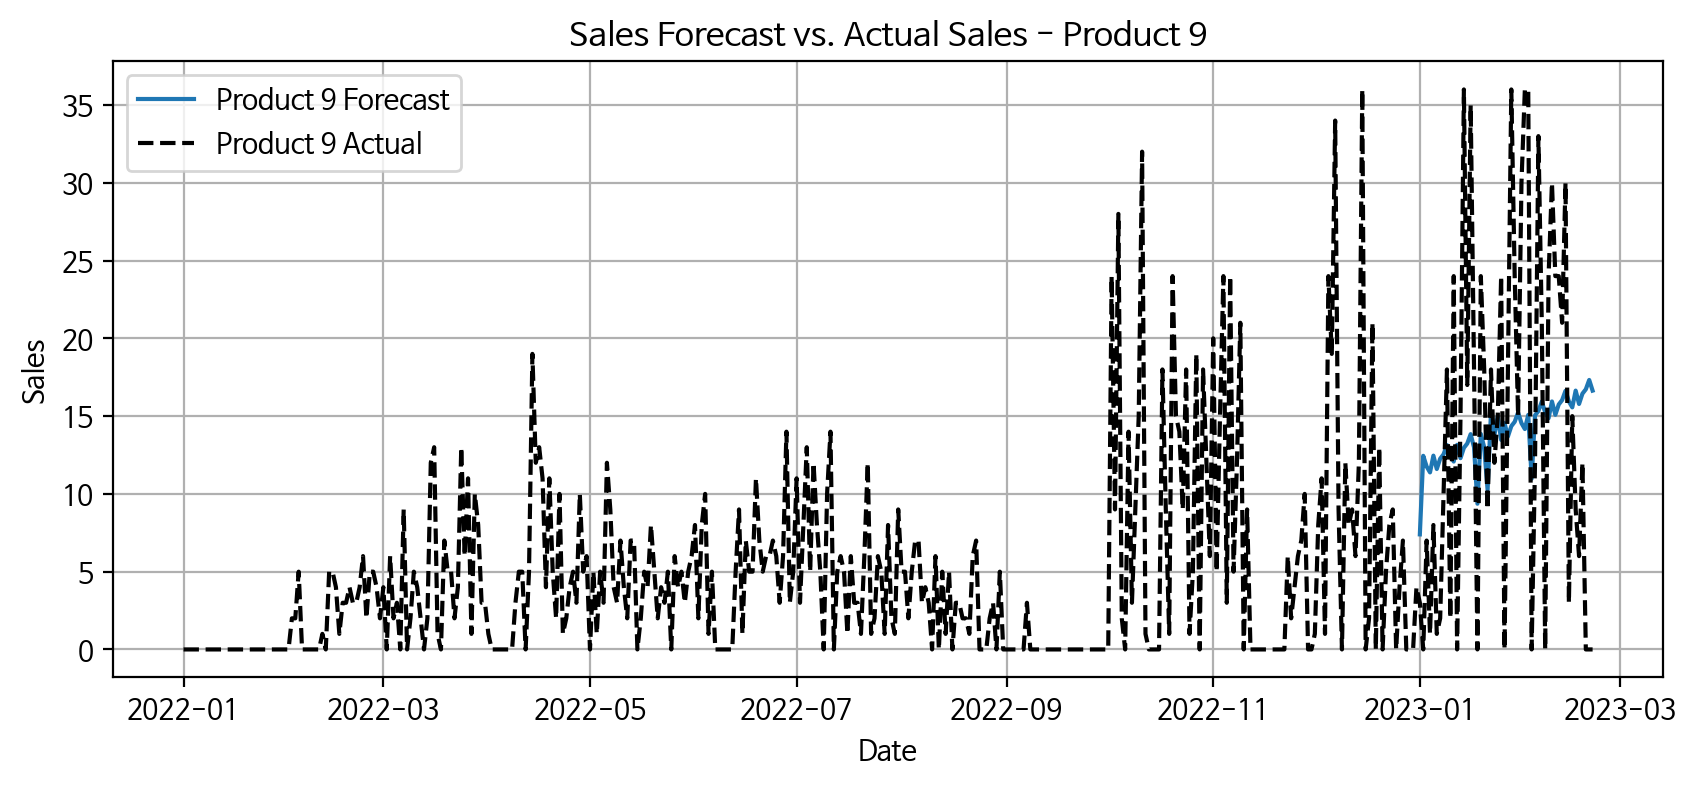

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=1288.064, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1296.155, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1286.443, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1285.932, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1294.155, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=1284.077, Time=0.09 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=1285.950, Time=0.16 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=1287.633, Time=0.56 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=1279.730, Time=0.15 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=1281.722, Time=0.42 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=1281.722, Time=0.38 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=1283.725, Time=0.47 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1284.463, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=1281.724, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
DEBUG:cmdstanpy:input tempfile: /tmp/tmppodq791u/fuc4_l7b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppodq791u/rjzjv64f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31802', 'data', 'file=/tmp/tmppodq791u/fuc4_l7b.json', 'init=/tmp/tm

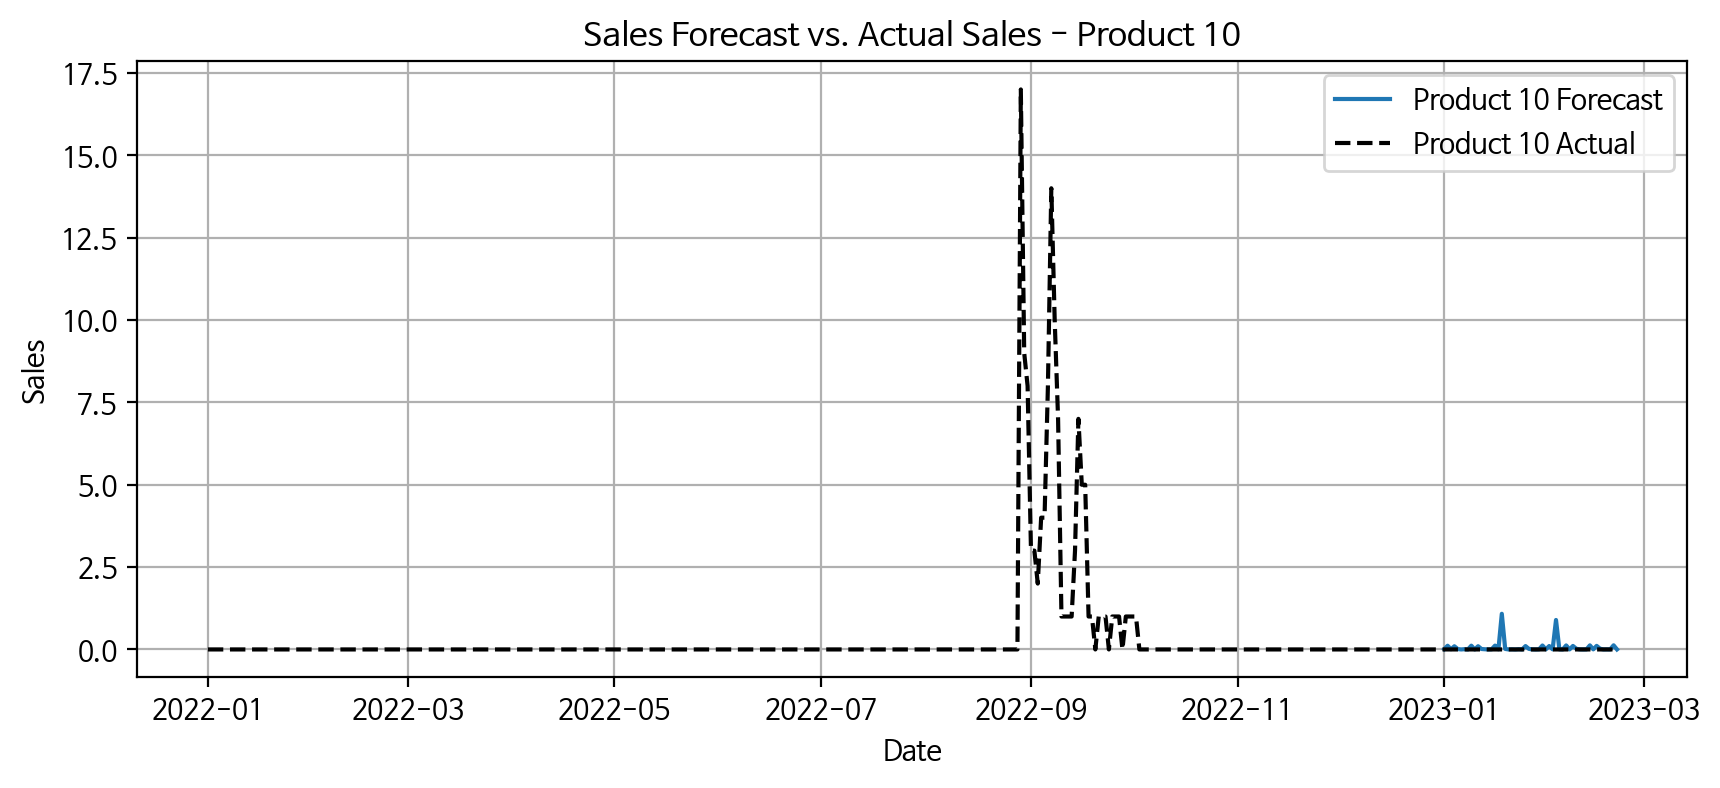

In [ ]:
import pmdarima as pm

# 원하는 10개의 제품 ID를 선택
fixed_product_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # 원하는 제품 ID를 명시적으로 지정하세요

# train 데이터프레임을 준비하세요.
train.set_index('time', inplace=True)

forecast_range = pd.date_range(start='2023-01-01', periods=52)

all_forecasts = {}

# 예측과 실제 값을 저장할 데이터프레임 생성
forecast_df = pd.DataFrame(index=forecast_range)

for product in fixed_product_ids:  # 랜덤 대신 고정된 제품 ID를 순회합니다.
    ts = train[train['ID'] == product]['sell']

    autoarima_model = pm.auto_arima(ts, saart_p=4, start_q=0, max_p=6, max_q=3, d=1,
                                    seasonal=True, start_P=1, start_Q=0, max_P=6, max_Q=3, D=0, max_D=2, m=7,
                                    error_action="ignore", max_order=None, trace=True)

    order = autoarima_model.order

    model = ARIMA(ts, order=order)
    model_fit = model.fit()
    forecast_arima = model_fit.forecast(steps=52)

    # Prophet 모델 피팅
    x_df = pd.DataFrame()
    x_df['ds'] = ts.index
    x_df['y'] = ts.values

    prophet = Prophet(seasonality_mode='additive',
                      yearly_seasonality=False,
                      weekly_seasonality='auto', daily_seasonality=False,
                      changepoint_prior_scale=0.5)
    prophet.add_country_holidays(country_name='KR')

    prophet.fit(x_df)

    future_data = prophet.make_future_dataframe(periods=52, freq='D')

    forecast_prophet = prophet.predict(future_data)

    # Prophet 모델의 예측 값을 ARIMA 모델의 예측 길이에 맞추기
    forecast_prophet = forecast_prophet[forecast_prophet['ds'].isin(forecast_range)]

    # ARIMA와 Prophet 모델의 예측 값을 최종 예측으로 조합
    max_forecast = np.maximum(forecast_arima, forecast_prophet['yhat'].values)
    max_forecast[max_forecast < 0] = 0

    all_forecasts[product] = max_forecast

    # 각 제품에 대한 예측 그래프 그리기
    plt.figure(figsize=(10, 4))
    plt.plot(forecast_range, max_forecast, label=f'Product {product} Forecast')
    plt.plot(ts.index, ts.values, label=f'Product {product} Actual', linestyle='--', color='black')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Sales Forecast vs. Actual Sales - Product {product}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 각 제품에 대한 평가 지표를 저장할 딕셔너리
evaluation_metrics = {}

for product in fixed_product_ids:
    ts = train[train['ID'] == product]['sell']
    actual_values = ts[-52:]  # 실제 값은 예측 기간의 마지막 52개 데이터입니다.

    # 모델이 예측한 값
    predicted_values = all_forecasts[product]

    # 평가 지표 계산
    mse = mean_squared_error(actual_values, predicted_values)
    mae = mean_absolute_error(actual_values, predicted_values)

    # 결과 저장
    evaluation_metrics[f'Product {product}'] = {'MSE': mse, 'MAE': mae}

# 평가 지표 출력
for product, metrics in evaluation_metrics.items():
    print(f'{product} - MSE: {metrics["MSE"]}, MAE: {metrics["MAE"]}')


Product 1 - MSE: 1.05764507123469, MAE: 0.8227662337091799
Product 2 - MSE: 0.4649383578632049, MAE: 0.4972621120648031
Product 3 - MSE: 10.432490755472447, MAE: 1.0711899800127667
Product 4 - MSE: 17.897979896147945, MAE: 3.899335674420306
Product 5 - MSE: 0.7587961944476954, MAE: 0.5677221012510172
Product 6 - MSE: 0.09027134132551559, MAE: 0.2105026324311227
Product 7 - MSE: 14.945302029010264, MAE: 2.470722131201472
Product 8 - MSE: 0.7630456579678158, MAE: 0.5890959515867022
Product 9 - MSE: 131.37088968818975, MAE: 9.650450779981238
Product 10 - MSE: 0.04106852428509662, MAE: 0.06953021000945739
